# Load_data

In [2450]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler,LabelEncoder,PowerTransformer,RobustScaler
import numpy as np
from sklearn.cluster import KMeans
import networkx as nx
from scipy.spatial import KDTree
from geopy.distance import geodesic
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestRegressor

In [2451]:
df=pd.read_csv('https://github.com/MajdBa7r/AQI/raw/main/ontario_wildfire_weather_pm_2017_2024_2.csv')

In [2452]:
df.head()

city        date      lat      lon      pm25  year  \
0     arnprior  2017-01-01  45.2001 -76.5278  2.090151  2017   
1     atikokan  2017-01-01  51.2216 -90.2304  0.128585  2017   
2     bancroft  2017-01-01  45.5890 -78.3437  2.089787  2017   
3   belleville  2017-01-01  44.4855 -77.4459  4.860390  2017   
4  bracebridge  2017-01-01  45.1669 -79.2325  6.356419  2017   

   precipitation_sum (mm)  rain_sum (mm)  snowfall_sum (cm)  \
0                     2.8            0.0               1.96   
1                     0.9            0.0               0.63   
2                     1.9            0.0               1.33   
3                     0.0            0.0               0.00   
4                     1.8            0.2               1.12   

   relative_humidity_2m_mean (%)  ...  index_right  OGF_ID  FIRE_TYPE_CODE  \
0                           80.0  ...          NaN     NaN             NaN   
1                           82.0  ...          NaN     NaN             NaN   
2                           82.0  ...          NaN     NaN             NaN   
3                           76.0  ...          NaN     NaN             NaN   
4                           84.0  ...          NaN     NaN             NaN   

   FIRE_YEAR  FIRE_GENERAL_CAUSE_CODE  FIRE_WEATHER_INDEX  \
0        NaN                      NaN                 NaN   
1        NaN                      NaN                 NaN   
2        NaN                      NaN                 NaN   
3        NaN                      NaN                 NaN   
4        NaN                      NaN                 NaN   

   FIRE_RESPONSE_OBJ_CODE  FIRE_START_DATE  FIRE_OUT_DATE  FIRE_FINAL_SIZE  
0                     NaN              NaN            NaN              NaN  
1                     NaN              NaN            NaN              NaN  
2                     NaN              NaN            NaN              NaN  
3                     NaN              NaN            NaN              NaN  
4                     NaN              NaN            NaN              NaN  

[5 rows x 34 columns]

In [2453]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139502 entries, 0 to 139501
Data columns (total 34 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   city                               139502 non-null  object 
 1   date                               139502 non-null  object 
 2   lat                                139502 non-null  float64
 3   lon                                139502 non-null  float64
 4   pm25                               139502 non-null  float64
 5   year                               139502 non-null  int64  
 6   precipitation_sum (mm)             139502 non-null  float64
 7   rain_sum (mm)                      139502 non-null  float64
 8   snowfall_sum (cm)                  139502 non-null  float64
 9   relative_humidity_2m_mean (%)      139502 non-null  float64
 10  relative_humidity_2m_max (%)       139502 non-null  float64
 11  relative_humidity_2m_min (%)       1395

In [2454]:
df.date=pd.to_datetime(df.date)
df.FIRE_START_DATE=pd.to_datetime(df.FIRE_START_DATE)
df.FIRE_OUT_DATE=pd.to_datetime(df.FIRE_OUT_DATE)

In [2455]:
df[['date','city']].duplicated().sum()

np.int64(2168)

Duplicates appear when merging by date and city because multiple wildfire events can occur in the same city on the same day. Each fire becomes a separate row, so when the dataset is merged with daily city-level data, one day can match multiple fire records. Aggregating the wildfire dataset by date and city (summing fire size or averaging fire indices) resolves this by producing a single consolidated record per day per city.

#Explode

In [2456]:
fire_cols_to_fill= [col for col in df.columns if col.startswith('FIRE_') or col == 'OGF_ID']
cols_needed = list(set(fire_cols_to_fill + ['FIRE_START_DATE', 'FIRE_OUT_DATE']))
df_fires_only= df.dropna(subset=['OGF_ID'])[cols_needed].copy()

In [2457]:
def get_date_range(row):
    return pd.date_range(row['FIRE_START_DATE'], row['FIRE_OUT_DATE']).to_list()
df_fires_only['date_range'] = df_fires_only.apply(get_date_range, axis=1)

In [2458]:
df_fires_ex=df_fires_only.explode('date_range')
df_fires_ex=df_fires_ex.rename(columns={'date_range': 'date'})
if 'FIRE_FINAL_SIZE' in df_fires_ex.columns:
    df_fires_ex=df_fires_ex.sort_values('FIRE_FINAL_SIZE', ascending=False)

In [2459]:
df_fires_ex = df_fires_ex.drop_duplicates(subset=['date'])

In [2460]:
cols_to_drop_from_main= [c for c in fire_cols_to_fill if c in df.columns]
df_weather_only= df.drop(columns=cols_to_drop_from_main)


df_final = pd.merge(df_weather_only, df_fires_ex, on='date', how='left')
df=df_final

This block prepares a clean fire events dataset and aligns it with the weather data at a daily level.
First, it selects all fire-related columns and keeps only rows that represent real fire incidents.
Then, for each fire record, it generates the full range of dates between the fire start and end dates in order to represent the fire as a daily event instead of a single record.

The dataset is then expanded so that each day of an active fire appears as a separate row.
To avoid data duplication conflicts, the data is sorted by fire size and duplicate dates are removed, keeping the most significant fire when overlaps exist.

After that, all original fire columns are removed from the main dataset to prevent redundancy.
Finally, the cleaned and expanded fire dataset is merged back into the main weather dataset based on the date, producing a unified time-aligned dataset where each day contains both weather conditions and the correct fire context.

In [2461]:
df[['date','city']].duplicated().sum()

np.int64(2168)

In [2462]:
df[df['OGF_ID'].notnull()].shape

(83666, 34)

In [2463]:
df[df['OGF_ID'].isnull()].shape

(55836, 34)

In [2464]:
df.shape

/usr/local/lib/python3.12/dist-packages/IPython/core/displayhook.py:275: UserWarning:

Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.



(139502, 34)

In [2465]:
df.columns

Index(['city', 'date', 'lat', 'lon', 'pm25', 'year', 'precipitation_sum (mm)',
       'rain_sum (mm)', 'snowfall_sum (cm)', 'relative_humidity_2m_mean (%)',
       'relative_humidity_2m_max (%)', 'relative_humidity_2m_min (%)',
       'dew_point_2m_mean (°C)', 'shortwave_radiation_sum (MJ/m²)',
       'sunshine_duration (s)', 'temperature_2m_mean (°C)',
       'temperature_2m_max (°C)', 'temperature_2m_min (°C)',
       'wind_speed_10m_mean (km/h)', 'wind_speed_10m_max (km/h)',
       'winddirection_10m_dominant (°)', 'vapour_pressure_deficit_max (kPa)',
       'et0_fao_evapotranspiration (mm)', 'geometry', 'index_right',
       'FIRE_TYPE_CODE', 'FIRE_START_DATE', 'FIRE_RESPONSE_OBJ_CODE',
       'FIRE_WEATHER_INDEX', 'FIRE_OUT_DATE', 'FIRE_YEAR', 'OGF_ID',
       'FIRE_FINAL_SIZE', 'FIRE_GENERAL_CAUSE_CODE'],
      dtype='object')

#not included

we fixed this issue in the main file

In [2466]:
'''df[(df['is_active']==False) & df['OGF_ID'].notnull()]'''

"df[(df['is_active']==False) & df['OGF_ID'].notnull()]"

Ok the reason is clear now. There’s an issue in the data input — the fire_out_date is before the fire_start_date, so the condition didn’t apply. We’ll fix it.

In [2467]:
'''a=df[(df['is_active']==False) & df['OGF_ID'].notnull()]
out=a.FIRE_START_DATE
start=a.FIRE_OUT_DATE
a=a.index'''

"a=df[(df['is_active']==False) & df['OGF_ID'].notnull()]\nout=a.FIRE_START_DATE\nstart=a.FIRE_OUT_DATE\na=a.index"

In [2468]:
'''out'''

'out'

In [2469]:
'''start'''

'start'

In [2470]:
'''df.loc[a, 'FIRE_START_DATE']= out
df.loc[a,'FIRE_OUT_DATE']=start'''

"df.loc[a, 'FIRE_START_DATE']= out\ndf.loc[a,'FIRE_OUT_DATE']=start"

In [2471]:
'''df['is_active']=(df['FIRE_START_DATE']<=df['date'])& (df['FIRE_OUT_DATE']>=df['date'])
df.is_active.value_counts()'''

"df['is_active']=(df['FIRE_START_DATE']<=df['date'])& (df['FIRE_OUT_DATE']>=df['date'])\ndf.is_active.value_counts()"

This is correct :)
 but this way is not the correct way to do what i need

# Aggregation

In [2472]:
data = df.groupby(['date', 'city']).agg({

    'FIRE_FINAL_SIZE': 'sum',
    'FIRE_WEATHER_INDEX': 'max',
    'FIRE_START_DATE': 'min',
    'FIRE_OUT_DATE': 'max',
    'OGF_ID': 'count',
    'FIRE_TYPE_CODE': 'first',
    'FIRE_GENERAL_CAUSE_CODE': 'first',
    'FIRE_RESPONSE_OBJ_CODE': 'first',
    'FIRE_YEAR': 'first',


    'geometry': 'first',
    'index_right': 'first',
    'lat': 'first',
    'lon': 'first',


    'pm25': 'first',
    'year': 'first',

    'precipitation_sum (mm)': 'first',
    'rain_sum (mm)': 'first',
    'snowfall_sum (cm)': 'first',
    'relative_humidity_2m_mean (%)': 'first',
    'relative_humidity_2m_max (%)': 'first',
    'relative_humidity_2m_min (%)': 'first',
    'dew_point_2m_mean (°C)': 'first',
    'shortwave_radiation_sum (MJ/m²)': 'first',
    'sunshine_duration (s)': 'first',
    'temperature_2m_mean (°C)': 'first',
    'temperature_2m_max (°C)': 'first',
    'temperature_2m_min (°C)': 'first',
    'wind_speed_10m_mean (km/h)': 'first',
    'wind_speed_10m_max (km/h)': 'first',
    'winddirection_10m_dominant (°)': 'first',
    'vapour_pressure_deficit_max (kPa)': 'first',
    'et0_fao_evapotranspiration (mm)': 'first'

}).reset_index()


data['FIRE_COUNT']=data['OGF_ID']
data=data.drop(columns=['OGF_ID'])
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137334 entries, 0 to 137333
Data columns (total 34 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   date                               137334 non-null  datetime64[ns]
 1   city                               137334 non-null  object        
 2   FIRE_FINAL_SIZE                    137334 non-null  float64       
 3   FIRE_WEATHER_INDEX                 81498 non-null   float64       
 4   FIRE_START_DATE                    81498 non-null   datetime64[ns]
 5   FIRE_OUT_DATE                      81498 non-null   datetime64[ns]
 6   FIRE_TYPE_CODE                     81498 non-null   object        
 7   FIRE_GENERAL_CAUSE_CODE            79336 non-null   object        
 8   FIRE_RESPONSE_OBJ_CODE             80370 non-null   object        
 9   FIRE_YEAR                          81498 non-null   float64       
 10  geometry            

In [2473]:
data[['date','city']].duplicated().sum()

np.int64(0)

This step aggregates the raw data into daily city-level observations.
Fire features are summarized using meaningful statistics, while weather and spatial variables are preserved.
The number of fire events per day is stored as FIRE_COUNT, and redundant identifiers are removed to create a clean, modeling-ready dataset.

Why did we make this step?

     This step is performed to convert the raw event-level data into a structured daily dataset.
     Aggregating by date and city reduces noise, avoids duplicate information, and aligns wildfire and weather features on the same temporal scale, making the data suitable for time-series modeling.

In [2474]:
data[data['FIRE_COUNT']==2]

date             city  FIRE_FINAL_SIZE  FIRE_WEATHER_INDEX  \
4857   2017-04-14       greenstone              2.0                10.5   
4885   2017-04-14      thunder bay              2.0                10.5   
5120   2017-04-19      thunder bay              3.6                 0.0   
6295   2017-05-14      thunder bay              7.4                 5.7   
6477   2017-05-18         red lake              7.4                 5.7   
...           ...              ...              ...                 ...   
132087 2024-09-11           hearst          37409.4                 1.0   
132266 2024-09-15      elliot lake          37409.4                 1.0   
132273 2024-09-15  greater sudbury          37409.4                 1.0   
132483 2024-09-19  rayside-balfour          37409.4                 1.0   
133214 2024-10-05       greenstone          37409.4                 1.0   

       FIRE_START_DATE FIRE_OUT_DATE FIRE_TYPE_CODE FIRE_GENERAL_CAUSE_CODE  \
4857        2017-04-14    2017-04-15            IFR                     RWY   
4885        2017-04-14    2017-04-15            IFR                     RWY   
5120        2017-04-19    2017-04-24            IFR                     LTG   
6295        2017-05-08    2017-05-26            IFR                     MIS   
6477        2017-05-08    2017-05-26            IFR                     MIS   
...                ...           ...            ...                     ...   
132087      2024-07-11    2024-10-16            IFR                     LTG   
132266      2024-07-11    2024-10-16            IFR                     LTG   
132273      2024-07-11    2024-10-16            IFR                     LTG   
132483      2024-07-11    2024-10-16            IFR                     LTG   
133214      2024-07-11    2024-10-16            IFR                     LTG   

       FIRE_RESPONSE_OBJ_CODE  FIRE_YEAR  ... sunshine_duration (s)  \
4857                      FUL     2017.0  ...              42399.27   
4885                      FUL     2017.0  ...              43551.86   
5120                      FUL     2017.0  ...              39600.00   
6295                      FUL     2017.0  ...              47905.07   
6477                      FUL     2017.0  ...              47832.41   
...                       ...        ...  ...                   ...   
132087                    MOD     2024.0  ...              41180.97   
132266                    MOD     2024.0  ...              40925.50   
132273                    MOD     2024.0  ...              41327.91   
132483                    MOD     2024.0  ...              40499.73   
133214                    MOD     2024.0  ...              34358.66   

        temperature_2m_mean (°C)  temperature_2m_max (°C)  \
4857                         5.6                     15.0   
4885                         3.6                      9.6   
5120                         4.3                      9.8   
6295                         6.9                     10.1   
6477                         5.1                     12.5   
...                          ...                      ...   
132087                      18.9                     26.1   
132266                      18.0                     23.6   
132273                      19.4                     26.5   
132483                      18.6                     26.3   
133214                      10.2                     17.0   

        temperature_2m_min (°C)  wind_speed_10m_mean (km/h)  \
4857                       -3.2                        10.2   
4885                       -1.3                         8.8   
5120                        1.5                        12.6   
6295                        2.8                         9.9   
6477                       -0.9                        15.3   
...                         ...                         ...   
132087                     13.7                        10.1   
132266                     13.0                         8.9   
132273    

# Handle the absence of a fire

In [2475]:
data.isnull().sum()

date                                      0
city                                      0
FIRE_FINAL_SIZE                           0
FIRE_WEATHER_INDEX                    55836
FIRE_START_DATE                       55836
FIRE_OUT_DATE                         55836
FIRE_TYPE_CODE                        55836
FIRE_GENERAL_CAUSE_CODE               57998
FIRE_RESPONSE_OBJ_CODE                56964
FIRE_YEAR                             55836
geometry                             134160
index_right                          134160
lat                                       0
lon                                       0
pm25                                      0
year                                      0
precipitation_sum (mm)                    0
rain_sum (mm)                             0
snowfall_sum (cm)                         0
relative_humidity_2m_mean (%)             0
relative_humidity_2m_max (%)              0
relative_humidity_2m_min (%)              0
dew_point_2m_mean (°C)                    0
shortwave_radiation_sum (MJ/m²)           0
sunshine_duration (s)                     0
temperature_2m_mean (°C)                  0
temperature_2m_max (°C)                   0
temperature_2m_min (°C)                   0
wind_speed_10m_mean (km/h)                0
wind_speed_10m_max (km/h)                 0
winddirection_10m_dominant (°)            0
vapour_pressure_deficit_max (kPa)         0
et0_fao_evapotranspiration (mm)           0
FIRE_COUNT                                0
dtype: int64

In [2476]:
data.drop(columns=['index_right','geometry'],inplace=True)

In [2477]:
zero_cols=['FIRE_WEATHER_INDEX','FIRE_START_DATE','FIRE_OUT_DATE','FIRE_TYPE_CODE','FIRE_YEAR']
data[zero_cols] = data[zero_cols].fillna(0)

We used this approach to replace missing values in key numeric and categorical fire-related columns with 0, indicating the absence of a fire.

In [2478]:
p1=data['FIRE_GENERAL_CAUSE_CODE']
p1.value_counts()

FIRE_GENERAL_CAUSE_CODE
LTG    51512
IDF     8272
REC     6627
MIS     6298
RES     3055
RWY     1222
INC      940
UNK      752
IDO      658
Name: count, dtype: int64

In [2479]:
mask=(data['FIRE_GENERAL_CAUSE_CODE'].isnull()) & (data['FIRE_START_DATE'] == 0)
data.loc[mask, 'FIRE_GENERAL_CAUSE_CODE'] = 'No_Fire'
p1.isnull().sum()

np.int64(2162)

We used this approach to fill missing FIRE_GENERAL_CAUSE_CODE values with 'No_Fire' for records where no fire occurred (FIRE_START_DATE is 0), ensuring that nulls accurately represent the absence of a fire.

In [2480]:
p2=data['FIRE_RESPONSE_OBJ_CODE']
p2.value_counts()

FIRE_RESPONSE_OBJ_CODE
FUL    36848
MON    25568
MOD    17484
MNP      376
MDP       94
Name: count, dtype: int64

In [2481]:
mask=(data['FIRE_RESPONSE_OBJ_CODE'].isnull()) & (data['FIRE_START_DATE'] == 0)
data.loc[mask, 'FIRE_RESPONSE_OBJ_CODE'] = 'No_Fire'
p2.isnull().sum()

np.int64(1128)

There are two types of missing values in the dataset: values that are naturally missing on days without any fire activity, and values that are missing within records of fires that actually occurred. After analysis, we found that the missing values within active fire records are np.int64(2162) for FIRE_GENERAL_CAUSE_CODE and np.int64(1128) for FIRE_RESPONSE_OBJ_CODE. Therefore, these missing entries will be imputed using information from the other days of the same fire event

# Lagging

Lagging: refers to using past values of a variable as features in time-series or sequential data to capture temporal dependencies and patterns.

**Important**

Using current-day fire data creates data leakage because this information is unavailable at the time of prediction, effectively giving the model the answer in advance. To resolve this, we implement lagging features by shifting fire statistics to the previous day, ensuring the model relies only on historical data. This approach allows the model to legitimately learn how yesterday's fires impact today's PM2.5 levels without violating temporal causality.

Lagging to ensure avoiding data leakage

In [2482]:
data['fire_size_lag1']=data.groupby('city')['FIRE_FINAL_SIZE'].shift(1)

This feature represents the **size of the previous day’s** fire in the same city, which helps the model understand whether fire events tend to escalate or follow patterns over time.

In [2483]:
data['fire_count_lag1'] = data.groupby('city')['FIRE_COUNT'].shift(1)

This feature indicates **how many fires occurred in the city on the previous day**, allowing the model to learn patterns related to repeated daily fire occurrences.

In [2484]:
#data['fire_size_7d_avg'] =data.groupby('city')['FIRE_FINAL_SIZE'].transform(lambda x: x.shift(1).rolling(7, min_periods=1).mean()).fillna(0)

In [2485]:
data['fire_size_7d_avg'] = (data.groupby('city')['FIRE_FINAL_SIZE'].rolling(7, min_periods=1).mean().reset_index(level=0, drop=True))

This feature represents **the 7-day moving average of fire size in each city**, providing the model with a smoothed historical trend of fire behavior over the past week

In [2486]:
#data['fire_size_7d_sum']=data.groupby('city')['FIRE_FINAL_SIZE'].transform(lambda x: x.shift(1).rolling(7, min_periods=1).sum()).fillna(0)

In [2487]:
data['fire_size_7d_sum'] = (data.groupby('city')['FIRE_FINAL_SIZE'].rolling(7, min_periods=1).sum().reset_index(level=0, drop=True))

instead of looking only at yesterday’s fire size, we consider the total area burned over the past week. Burned land and rising smoke accumulate and persist for several days.

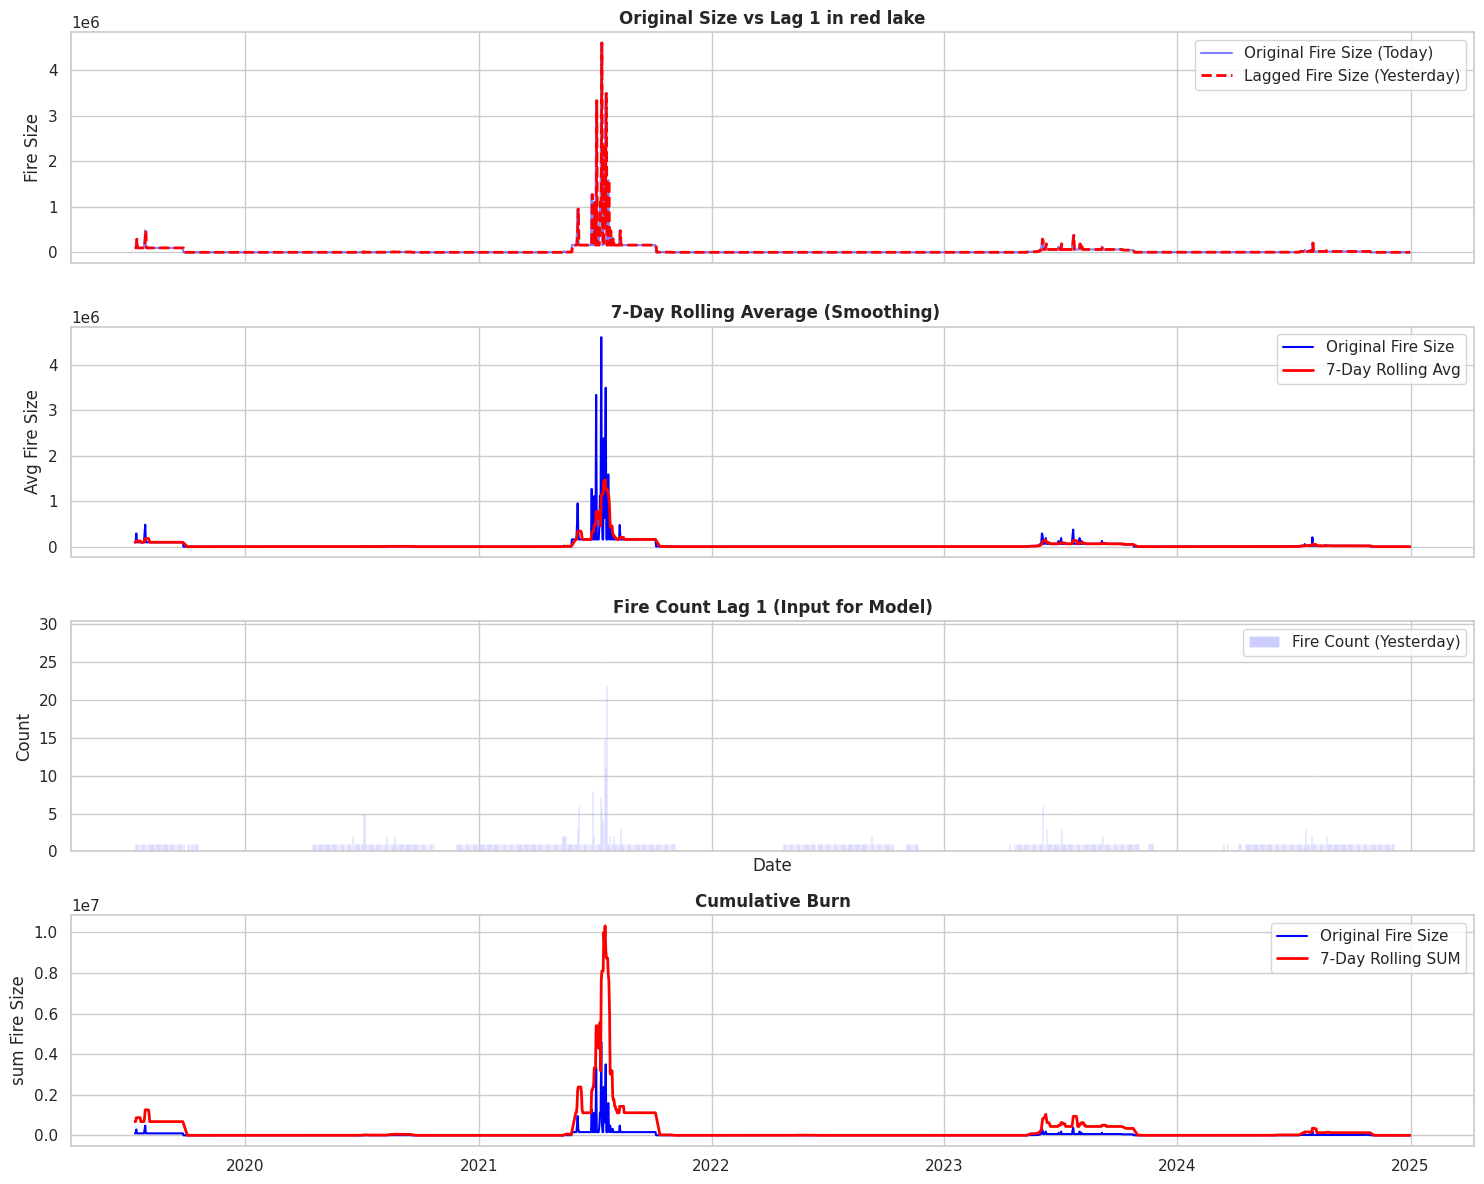

In [2488]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (15, 12)

top_city = data.groupby('city')['FIRE_COUNT'].sum().idxmax()

df_plot = data[data['city'] == top_city].copy()
df_plot = df_plot.sort_values('date')
df_plot = df_plot.iloc[-2000:]

fig, axes = plt.subplots(4, 1, sharex=True)


axes[0].plot(df_plot['date'],df_plot['FIRE_FINAL_SIZE'],label='Original Fire Size (Today)',color='blue',alpha=0.5)
axes[0].plot(df_plot['date'],df_plot['fire_size_lag1'],label='Lagged Fire Size (Yesterday)',color='red',linestyle='--', linewidth=2)
axes[0].set_title(f'Original Size vs Lag 1 in {top_city}', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].set_ylabel('Fire Size')


axes[1].plot(df_plot['date'],df_plot['FIRE_FINAL_SIZE'],label='Original Fire Size',color='blue')
axes[1].plot(df_plot['date'], df_plot['fire_size_7d_avg'],label='7-Day Rolling Avg',color='red',linewidth=2)
axes[1].set_title(' 7-Day Rolling Average (Smoothing)',fontsize=12,fontweight='bold')
axes[1].legend()
axes[1].set_ylabel('Avg Fire Size')


axes[2].bar(df_plot['date'],df_plot['fire_count_lag1'],color='blue',alpha=0.2,label='Fire Count (Yesterday)')
axes[2].set_title('Fire Count Lag 1 (Input for Model)',fontsize=12,fontweight='bold')
axes[2].legend()
axes[2].set_ylabel('Count')
axes[2].set_xlabel('Date')


axes[3].plot(df_plot['date'],df_plot['FIRE_FINAL_SIZE'],label='Original Fire Size',color='blue')
axes[3].plot(df_plot['date'], df_plot['fire_size_7d_sum'],label='7-Day Rolling SUM',color='red',linewidth=2)
axes[3].set_title('Cumulative Burn',fontsize=12,fontweight='bold')
axes[3].legend()
axes[3].set_ylabel('sum Fire Size')
plt.tight_layout()
plt.show()

**plot 1:**

The very large spikes represent major fire events, while the red dashed line shows how the previous day's fire size behaves relative to today.
We can observe that fire sizes tend to rise and fall in clusters, indicating that large fires often persist for several consecutive days rather than appearing as isolated events.

**plot 2:**

shows the smoothed fire sizes using a 7-day moving average.
The smoothing substantially reduces daily noise and makes long-duration fire periods more visible.
Major fire seasons clearly stand out (e.g., 2021), showing sustained high fire activity across multiple days rather than isolated spikes.
This smoothed trend is helpful for modeling because it captures the underlying pattern of fire progression without the extreme day-to-day fluctuations.

**plot 3:**

This plot displays the number of fires per day (lagged by one day).
Most days have very low fire counts, but occasional peaks occur during active fire seasons.

**plot 4:**
This plot compares the daily fire size (blue) with the 7-day rolling cumulative burn (red).
While the blue line shows the fire size on each individual day, the red line represents the total area burned over the previous week, capturing how fire impact accumulates over time


**Always split first. Then scale/encode/transform only the training set.
Test set gets only transform, never fit.**

#Time_based Spliting


In [2489]:
data.date=pd.to_datetime(data.date)
data.FIRE_START_DATE=pd.to_datetime(data.FIRE_START_DATE)
data.FIRE_OUT_DATE=pd.to_datetime(data.FIRE_OUT_DATE)

In [2490]:
X=data.drop(columns=["pm25"])
y=data["pm25"]

In [2491]:
tscv = TimeSeriesSplit(n_splits=4)

Split 1:
Train dates: 2017-01-01 00:00:00 → 2018-08-08 00:00:00
Test  dates: 2018-08-08 00:00:00 → 2020-03-14 00:00:00
Train size: 27470 Test size: 27466
--------------------------------------------------
Split 2:
Train dates: 2017-01-01 00:00:00 → 2020-03-14 00:00:00
Test  dates: 2020-03-14 00:00:00 → 2021-10-20 00:00:00
Train size: 54936 Test size: 27466
--------------------------------------------------
Split 3:
Train dates: 2017-01-01 00:00:00 → 2021-10-20 00:00:00
Test  dates: 2021-10-20 00:00:00 → 2023-05-27 00:00:00
Train size: 82402 Test size: 27466
--------------------------------------------------
Split 4:
Train dates: 2017-01-01 00:00:00 → 2023-05-27 00:00:00
Test  dates: 2023-05-27 00:00:00 → 2024-12-31 00:00:00
Train size: 109868 Test size: 27466
--------------------------------------------------


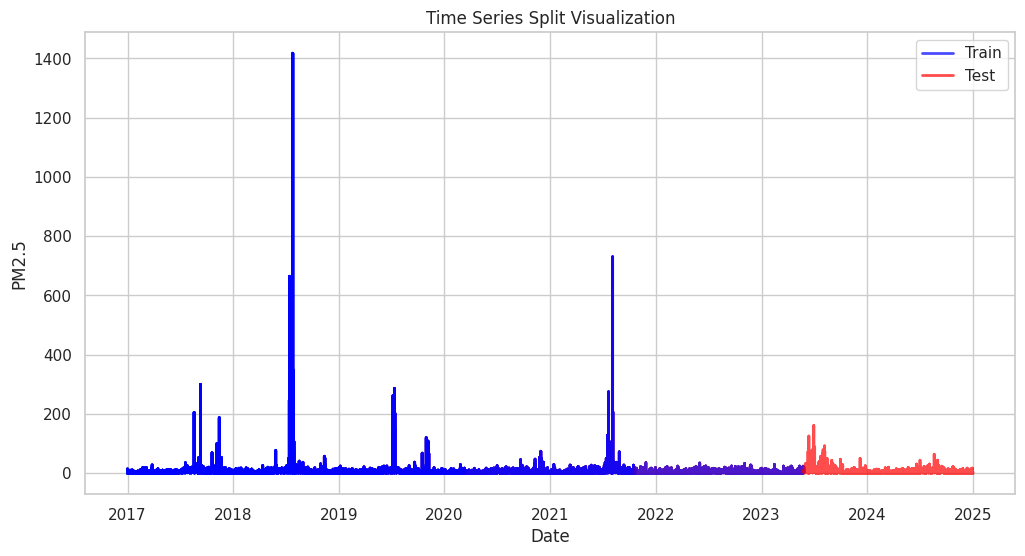

In [2492]:
plt.figure(figsize=(12, 6))
for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    print(f"Split {i+1}:")
    print("Train dates:", X_train['date'].min(), "→", X_train['date'].max())
    print("Test  dates:", X_test['date'].min(), "→", X_test['date'].max())
    print("Train size:", len(X_train), "Test size:", len(X_test))
    print("-"*50)

    # Plot training data
    plt.plot(X_train['date'], y_train, color='blue', linewidth=2, label='Train' if i==0 else "", alpha=0.7)
    # Plot test data
    plt.plot(X_test['date'], y_test, color='red', linewidth=2, label='Test' if i==0 else "", alpha=0.7)

plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.title('Time Series Split Visualization')
plt.legend()
plt.grid(True)
plt.show()

In [2493]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 109868 entries, 0 to 109867
Data columns (total 35 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   date                               109868 non-null  datetime64[ns]
 1   city                               109868 non-null  object        
 2   FIRE_FINAL_SIZE                    109868 non-null  float64       
 3   FIRE_WEATHER_INDEX                 109868 non-null  float64       
 4   FIRE_START_DATE                    109868 non-null  datetime64[ns]
 5   FIRE_OUT_DATE                      109868 non-null  datetime64[ns]
 6   FIRE_TYPE_CODE                     109868 non-null  object        
 7   FIRE_GENERAL_CAUSE_CODE            108646 non-null  object        
 8   FIRE_RESPONSE_OBJ_CODE             108787 non-null  object        
 9   FIRE_YEAR                          109868 non-null  float64       
 10  lat                      

#Cleaning

**missing values**

In [2494]:
X_train.isnull().sum()

date                                    0
city                                    0
FIRE_FINAL_SIZE                         0
FIRE_WEATHER_INDEX                      0
FIRE_START_DATE                         0
FIRE_OUT_DATE                           0
FIRE_TYPE_CODE                          0
FIRE_GENERAL_CAUSE_CODE              1222
FIRE_RESPONSE_OBJ_CODE               1081
FIRE_YEAR                               0
lat                                     0
lon                                     0
year                                    0
precipitation_sum (mm)                  0
rain_sum (mm)                           0
snowfall_sum (cm)                       0
relative_humidity_2m_mean (%)           0
relative_humidity_2m_max (%)            0
relative_humidity_2m_min (%)            0
dew_point_2m_mean (°C)                  0
shortwave_radiation_sum (MJ/m²)         0
sunshine_duration (s)                   0
temperature_2m_mean (°C)                0
temperature_2m_max (°C)                 0
temperature_2m_min (°C)                 0
wind_speed_10m_mean (km/h)              0
wind_speed_10m_max (km/h)               0
winddirection_10m_dominant (°)          0
vapour_pressure_deficit_max (kPa)       0
et0_fao_evapotranspiration (mm)         0
FIRE_COUNT                              0
fire_size_lag1                         47
fire_count_lag1                        47
fire_size_7d_avg                        0
fire_size_7d_sum                        0
dtype: int64

In [2495]:
X_train['fire_count_lag1'] = X_train['fire_count_lag1'].fillna(0)
X_train['fire_size_lag1'] = X_train['fire_size_lag1'].fillna(0)

X_test['fire_count_lag1'] = X_test['fire_count_lag1'].fillna(0)
X_test['fire_size_lag1'] = X_test['fire_size_lag1'].fillna(0)

Since we shifted the data by 1 day to capture yesterday's effects, the first date has no preceding record to reference, resulting in NaN values

Fill missing values that indicate actual fire events

In [2496]:
cols_to_fix=['FIRE_GENERAL_CAUSE_CODE','FIRE_RESPONSE_OBJ_CODE']

In [2497]:
'''cols_to_fix=['FIRE_GENERAL_CAUSE_CODE','FIRE_RESPONSE_OBJ_CODE']
X_train[cols_to_fix] =X_train.groupby('city')[cols_to_fix].bfill()
X_test[cols_to_fix] =X_test.groupby('city')[cols_to_fix].bfill()'''

"cols_to_fix=['FIRE_GENERAL_CAUSE_CODE','FIRE_RESPONSE_OBJ_CODE']\nX_train[cols_to_fix] =X_train.groupby('city')[cols_to_fix].bfill()\nX_test[cols_to_fix] =X_test.groupby('city')[cols_to_fix].bfill()"

In [2498]:
print(X_train.isnull().sum().sum())
print(X_test.isnull().sum().sum())

2303
987


This approach is correct, but I will use a method that considers the city to ensure the fire cause is more accurately assigned

In [2499]:
second_mode_by_city = {}

for col in cols_to_fix:
    best_values = []
    for city, group in X_train.groupby('city'):
        counts = group[col].dropna().value_counts()
        if counts.empty:
            best = "No fire"
        else:
            best = counts.index[0]
        best_values.append({'city': city, f'{col}_best': best})

    best_values_df = pd.DataFrame(best_values)
    second_mode_by_city[col] = best_values_df


    X_train = X_train.merge(best_values_df, on='city', how='left')
    X_train[col] = X_train[col].fillna(X_train[f'{col}_best'])
    X_train = X_train.drop(columns=[f'{col}_best'])


for col in cols_to_fix:
    X_test = X_test.merge(second_mode_by_city[col], on='city', how='left')
    X_test[col] = X_test[col].fillna(X_test[f'{col}_best'])
    X_test = X_test.drop(columns=[f'{col}_best'])

Fill missing values per city using the most frequent fire value within that city.

If there’s no valid fire value in a city, fill it with the default "No fire".

All missing values are filled first using city-specific most frequent values, then default "No fire" if no valid value exists.

This ensures there are no NaNs before training, providing complete and reliable data for the model

In [2500]:
print(X_train.isnull().sum().sum())
print(X_test.isnull().sum().sum())

0
0


In [2501]:
cause=X_train['FIRE_GENERAL_CAUSE_CODE'].value_counts()
cause=cause[1:]

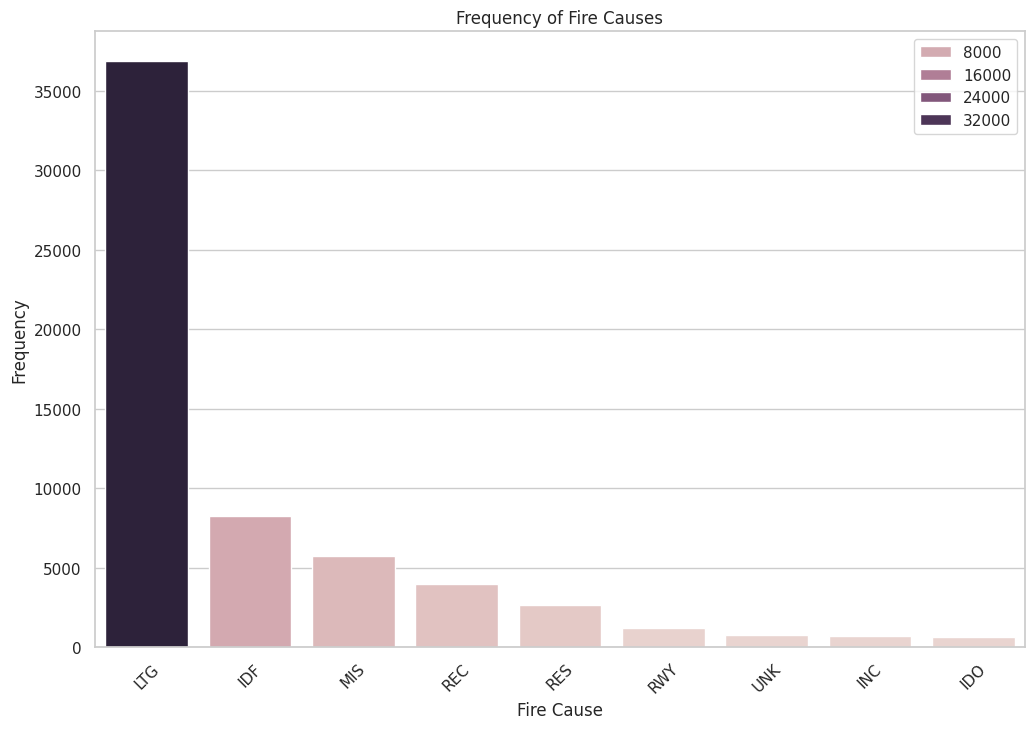

In [2502]:
plt.figure(figsize=(12, 8))
sns.barplot(x=cause.index, y=cause.values, hue=cause.values)
plt.xlabel('Fire Cause')
plt.ylabel('Frequency')
plt.title('Frequency of Fire Causes')
plt.xticks(rotation=45)
plt.show()

The plot clearly demonstrates that Lightning (LTG) is the overwhelmingly dominant cause of wildfires in your dataset, with a frequency exceeding 35,000 incidents, which is significantly higher than all other causes combined.

**Outliers**

In [2503]:
numeric_cols=X_train.select_dtypes(include='number').drop(columns=['lon','lat','year','FIRE_YEAR']).columns
Q1=X_train[numeric_cols].quantile(0.25)
Q3=X_train[numeric_cols].quantile(0.75)
IQR=Q3-Q1
outliers=(X_train[numeric_cols] < (Q1 - 1.5 * IQR)) | (X_train[numeric_cols] > (Q3 + 1.5 * IQR))

In [2504]:
outliers.sum()

FIRE_FINAL_SIZE                      23986
FIRE_WEATHER_INDEX                   12766
precipitation_sum (mm)               13736
rain_sum (mm)                        19456
snowfall_sum (cm)                    24751
relative_humidity_2m_mean (%)         2935
relative_humidity_2m_max (%)          3083
relative_humidity_2m_min (%)           247
dew_point_2m_mean (°C)                 133
shortwave_radiation_sum (MJ/m²)          0
sunshine_duration (s)                    0
temperature_2m_mean (°C)                20
temperature_2m_max (°C)                  2
temperature_2m_min (°C)                 50
wind_speed_10m_mean (km/h)            2369
wind_speed_10m_max (km/h)             2371
winddirection_10m_dominant (°)           0
vapour_pressure_deficit_max (kPa)     2990
et0_fao_evapotranspiration (mm)        306
FIRE_COUNT                             333
fire_size_lag1                       23939
fire_count_lag1                        333
fire_size_7d_avg                     24293
fire_size_7d_sum                     24293
dtype: int64

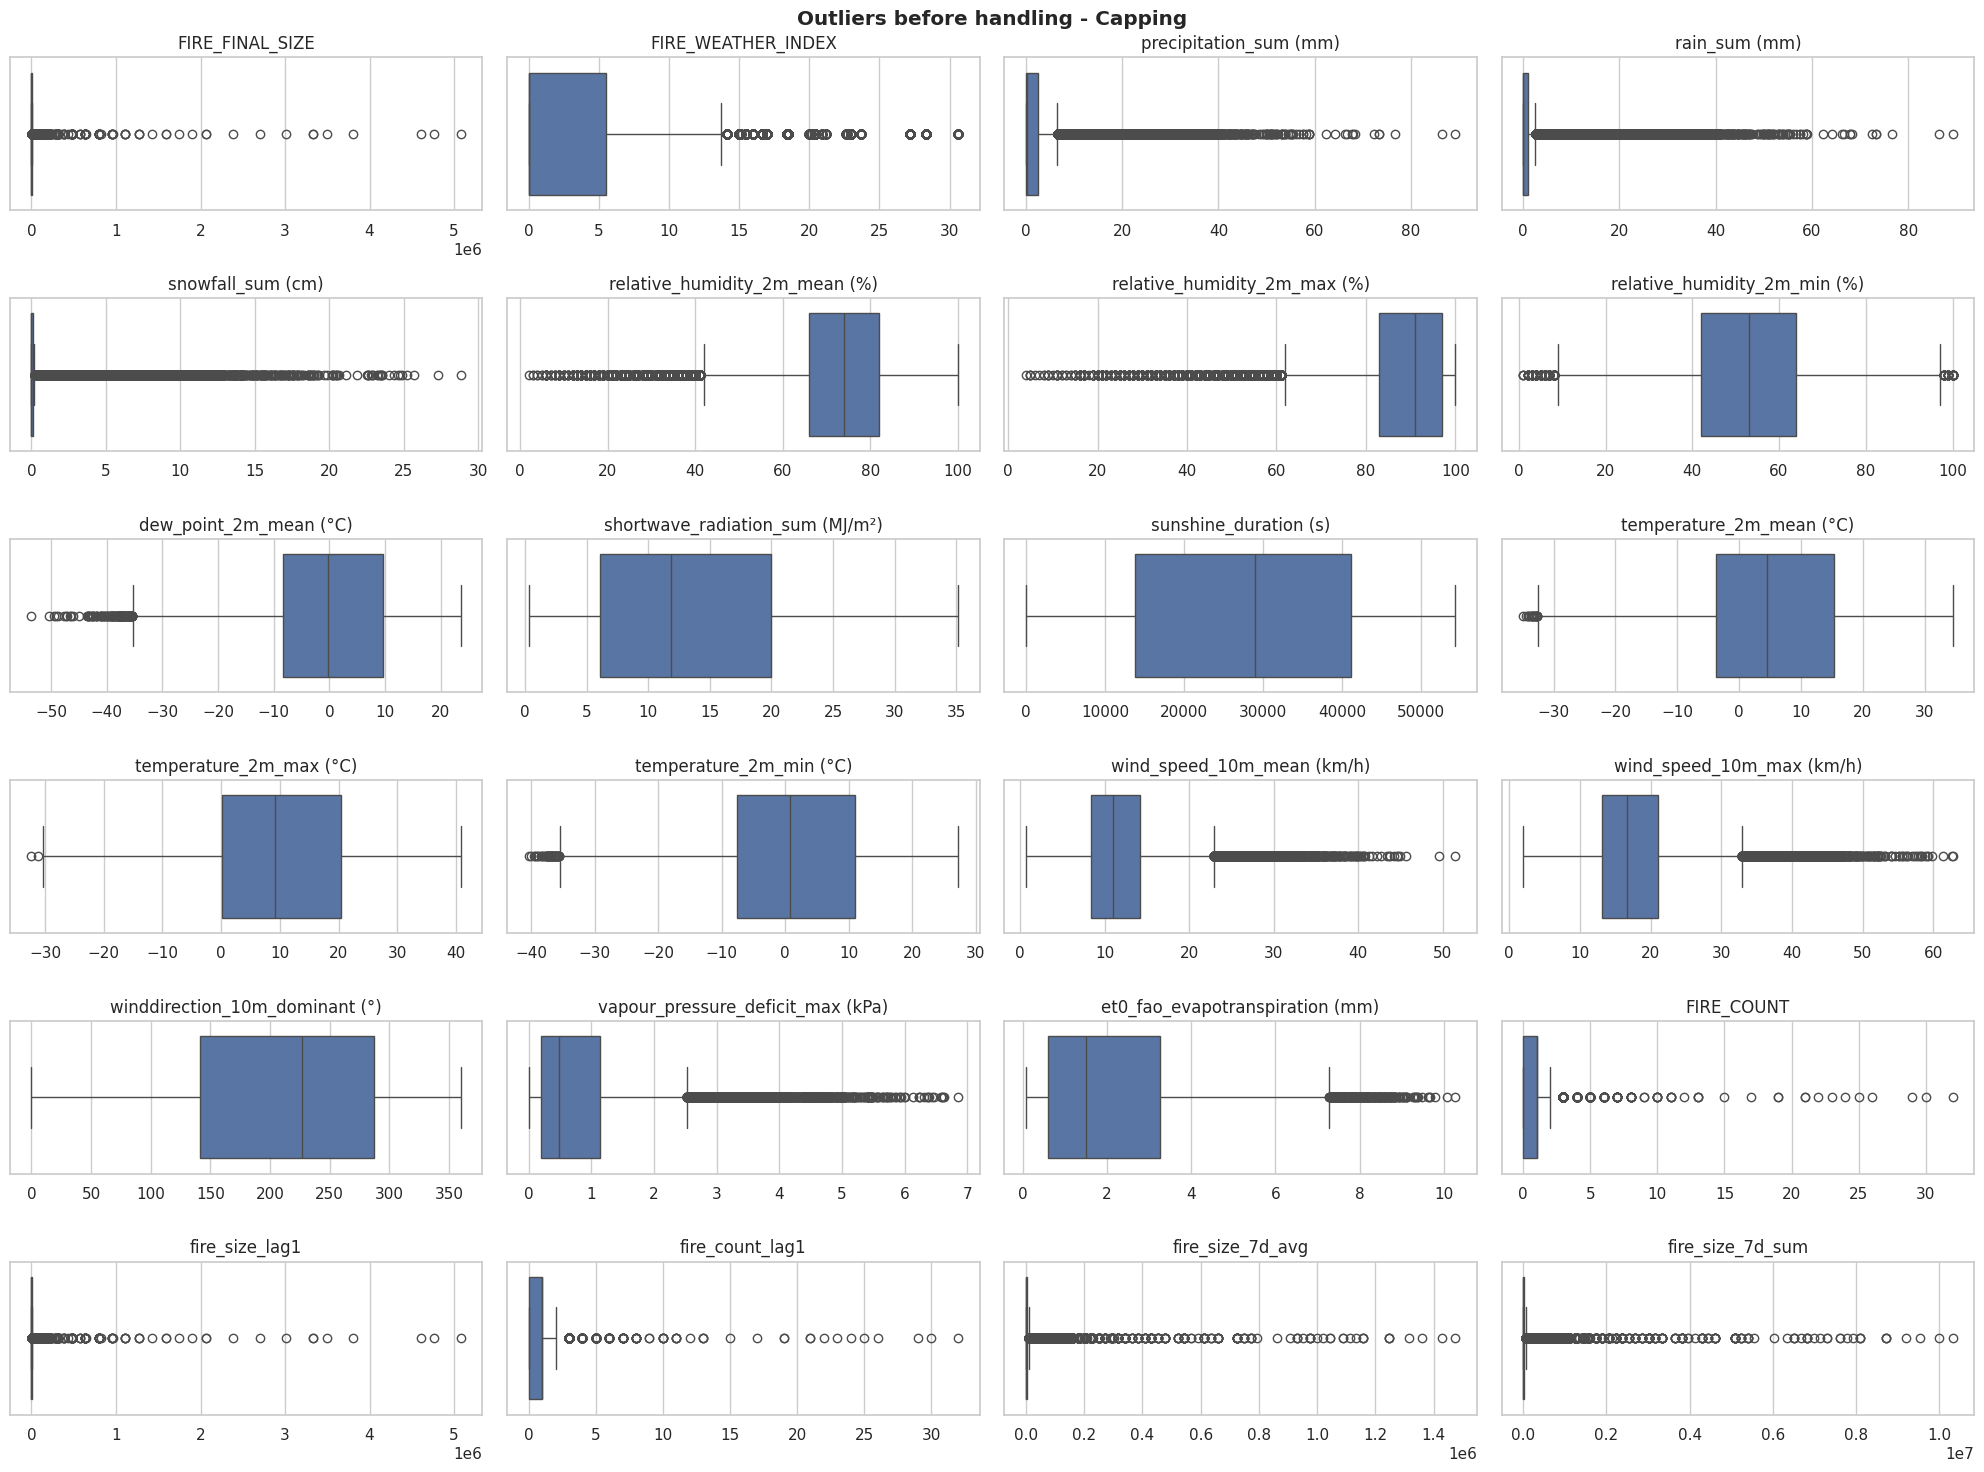

In [2505]:
fig,ax=plt.subplots(6,4,figsize=(20,15))
ax=ax.flatten()

for i,s in enumerate(numeric_cols):
   Min=Q1[s]-1.5*IQR[s]
   Max=Q3[s]+1.5*IQR[s]
   sns.boxplot(x=X_train[s],ax=ax[i])
   ax[i].set_title(s)
   ax[i].set_xlabel('')

for j in range(len(numeric_cols), len(ax)):
    fig.delaxes(ax[j])

plt.suptitle('Outliers before handling - Capping',weight='bold')
plt.tight_layout()
plt.show()

We will treat fire-related outliers and weather-related outliers differently:

**Fire Data:**
Fire intensity and burned area measurements can naturally contain extreme values because real fire events are highly variable and can escalate rapidly.These “outliers” are part of the real behavior of wildfires, not errors.For this reason, we do NOT remove or modify outliers in the fire dataset,
as doing so would distort the true fire patterns and reduce the model's ability
to learn from real high-impact events.

**Weather Data:**
Weather features (temperature, humidity, wind, etc.) may include outliers
caused by faulty sensors, recording issues, or data entry mistakes.
These outliers can negatively affect model training and scaling.
Therefore, we perform outlier detection and handling only on the weather variables
to improve data quality and ensure stable model performance.


In [2506]:
weather_features=["precipitation_sum (mm)","rain_sum (mm)","snowfall_sum (cm)","relative_humidity_2m_mean (%)",
"relative_humidity_2m_max (%)","relative_humidity_2m_min (%)","dew_point_2m_mean (°C)","shortwave_radiation_sum (MJ/m²)","sunshine_duration (s)",
"temperature_2m_mean (°C)","temperature_2m_max (°C)","temperature_2m_min (°C)","wind_speed_10m_mean (km/h)","wind_speed_10m_max (km/h)",
    "winddirection_10m_dominant (°)", "vapour_pressure_deficit_max (kPa)", "et0_fao_evapotranspiration (mm)"
]
Q25 = X_train[weather_features].quantile(0.25)
Q75 = X_train[weather_features].quantile(0.75)
IQR = Q75 - Q25
for f in weather_features:
    lower = Q25[f] - 1.5 * IQR[f]
    upper = Q75[f] + 1.5 * IQR[f]
    X_train[f] = X_train[f].clip(lower,upper)
    X_test[f] = X_test[f].clip(lower,upper)

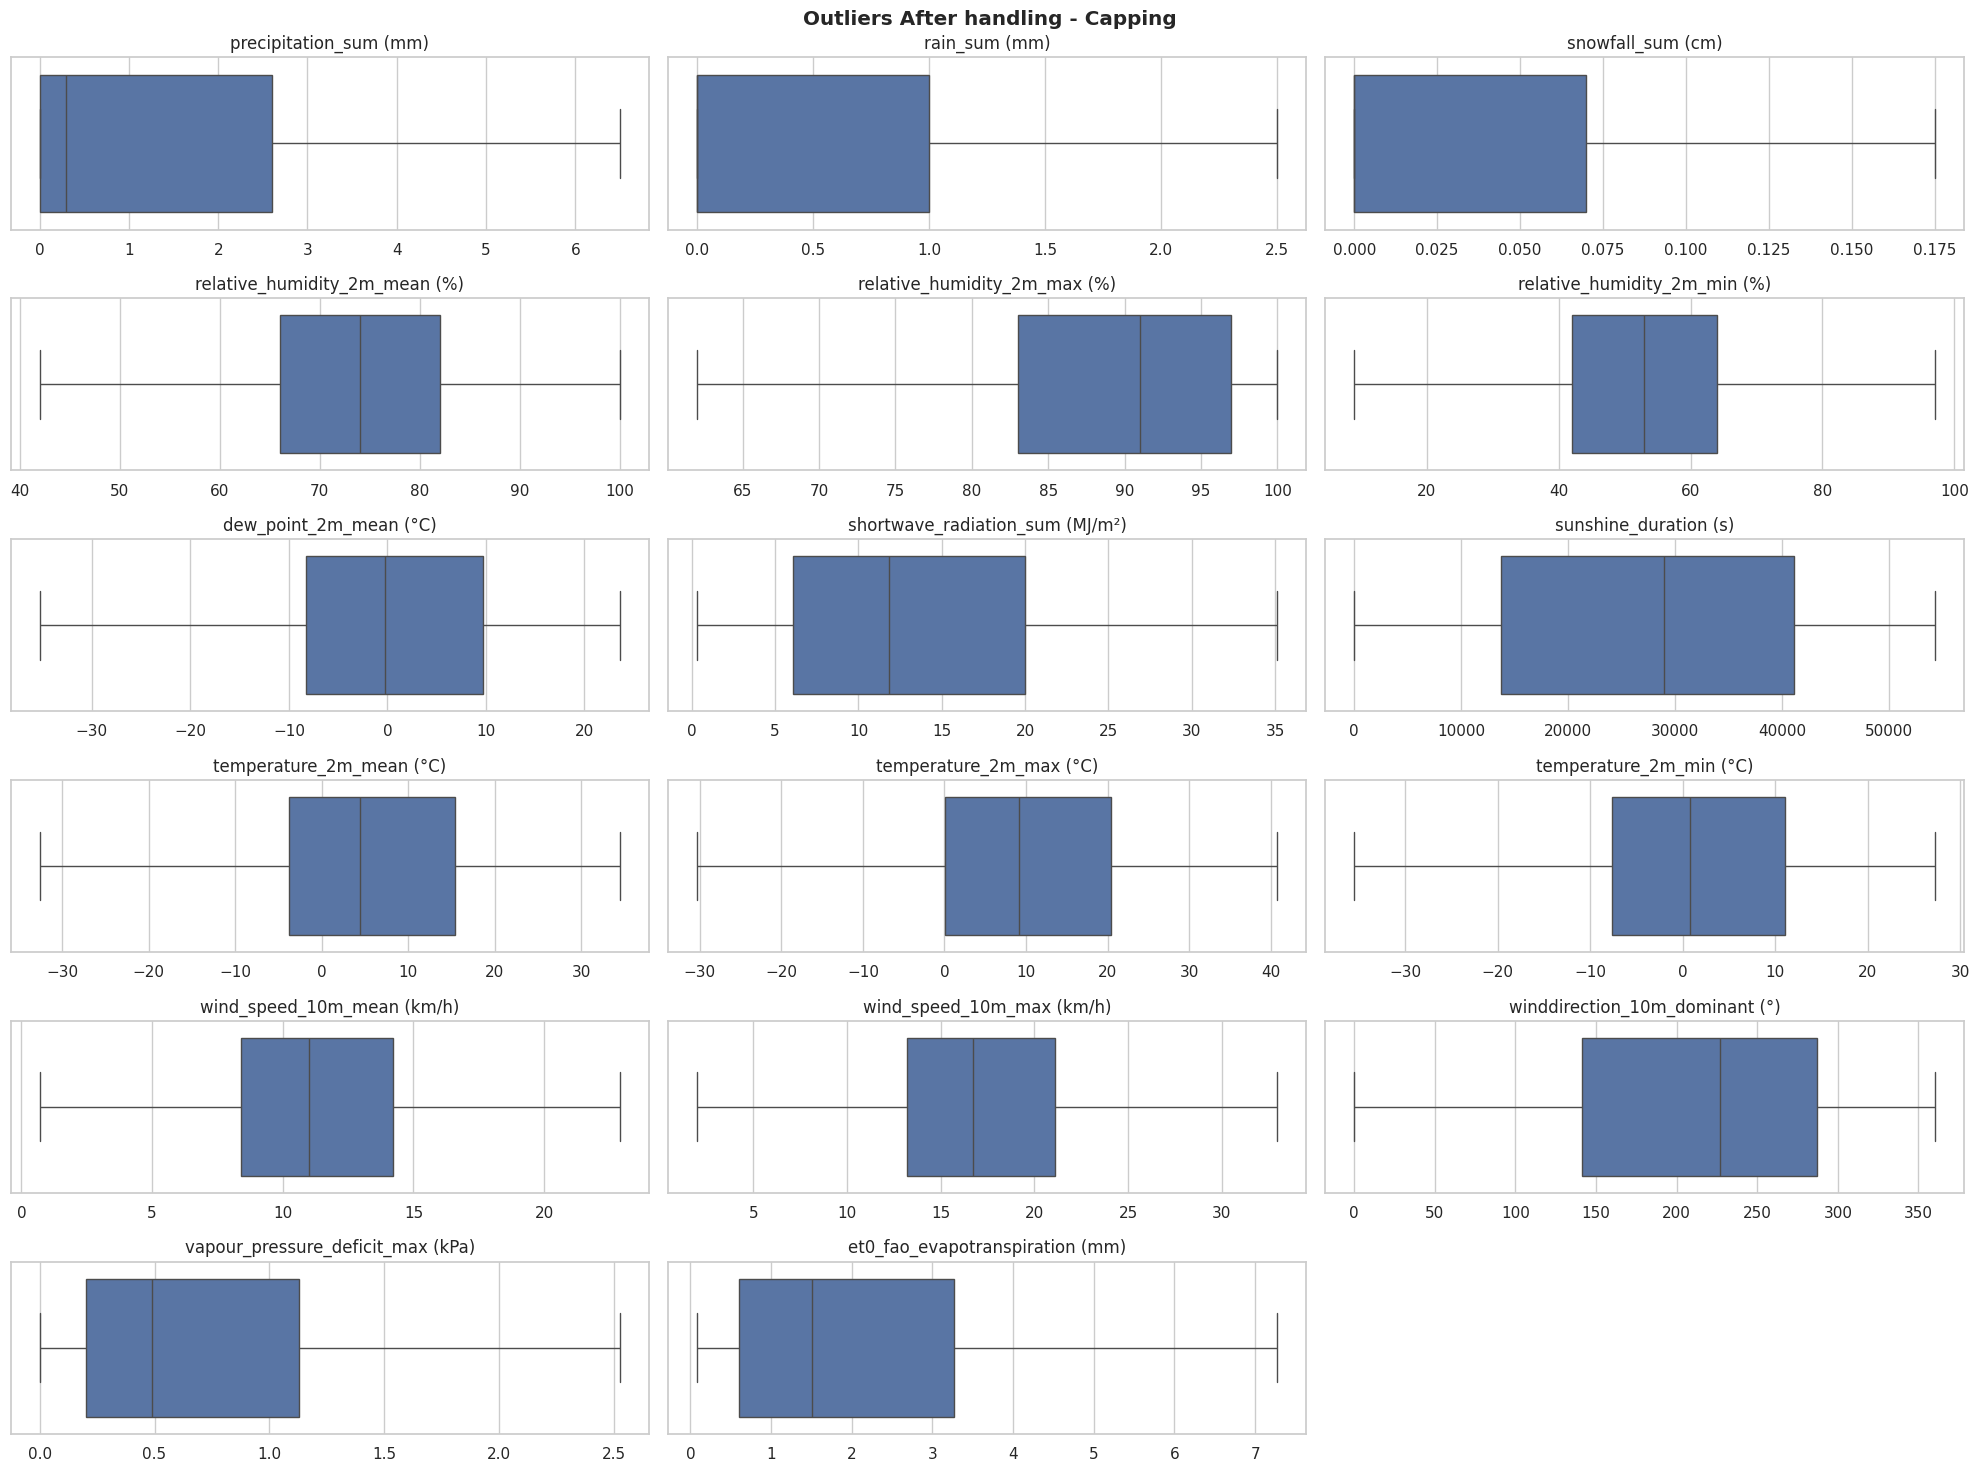

In [2507]:
fig,ax=plt.subplots(6,3,figsize=(20,15))
ax=ax.flatten()

for i,s in enumerate(weather_features):
   Min=Q25[s]-1.5*IQR[s]
   Max=Q75[s]+1.5*IQR[s]
   sns.boxplot(x=X_train[s],ax=ax[i])
   ax[i].set_title(s)
   ax[i].set_xlabel('')

for j in range(len(weather_features), len(ax)):
    fig.delaxes(ax[j])

plt.suptitle('Outliers After handling - Capping',weight='bold')
plt.tight_layout()
plt.show()

In [2508]:
numeric_cols=X_train.select_dtypes(include='number').drop(columns=['lon','lat','year','FIRE_YEAR']).columns
Q1=X_train[numeric_cols].quantile(0.25)
Q3=X_train[numeric_cols].quantile(0.75)
IQR=Q3-Q1
outliers=(X_train[numeric_cols] < (Q1 - 1.5 * IQR)) | (X_train[numeric_cols] > (Q3 + 1.5 * IQR))
outliers.sum()

FIRE_FINAL_SIZE                      23986
FIRE_WEATHER_INDEX                   12766
precipitation_sum (mm)                   0
rain_sum (mm)                            0
snowfall_sum (cm)                        0
relative_humidity_2m_mean (%)            0
relative_humidity_2m_max (%)             0
relative_humidity_2m_min (%)             0
dew_point_2m_mean (°C)                   0
shortwave_radiation_sum (MJ/m²)          0
sunshine_duration (s)                    0
temperature_2m_mean (°C)                 0
temperature_2m_max (°C)                  0
temperature_2m_min (°C)                  0
wind_speed_10m_mean (km/h)               0
wind_speed_10m_max (km/h)                0
winddirection_10m_dominant (°)           0
vapour_pressure_deficit_max (kPa)        0
et0_fao_evapotranspiration (mm)          0
FIRE_COUNT                             333
fire_size_lag1                       23939
fire_count_lag1                        333
fire_size_7d_avg                     24293
fire_size_7d_sum                     24293
dtype: int64

Why **Capping** Is the Best Choice for Weather Features?
because weather cannot logically jump to extreme unrealistic values, applying capping (winsorization) helps to
reduce the influence of noise and faulty sensor reading

**Skewness**

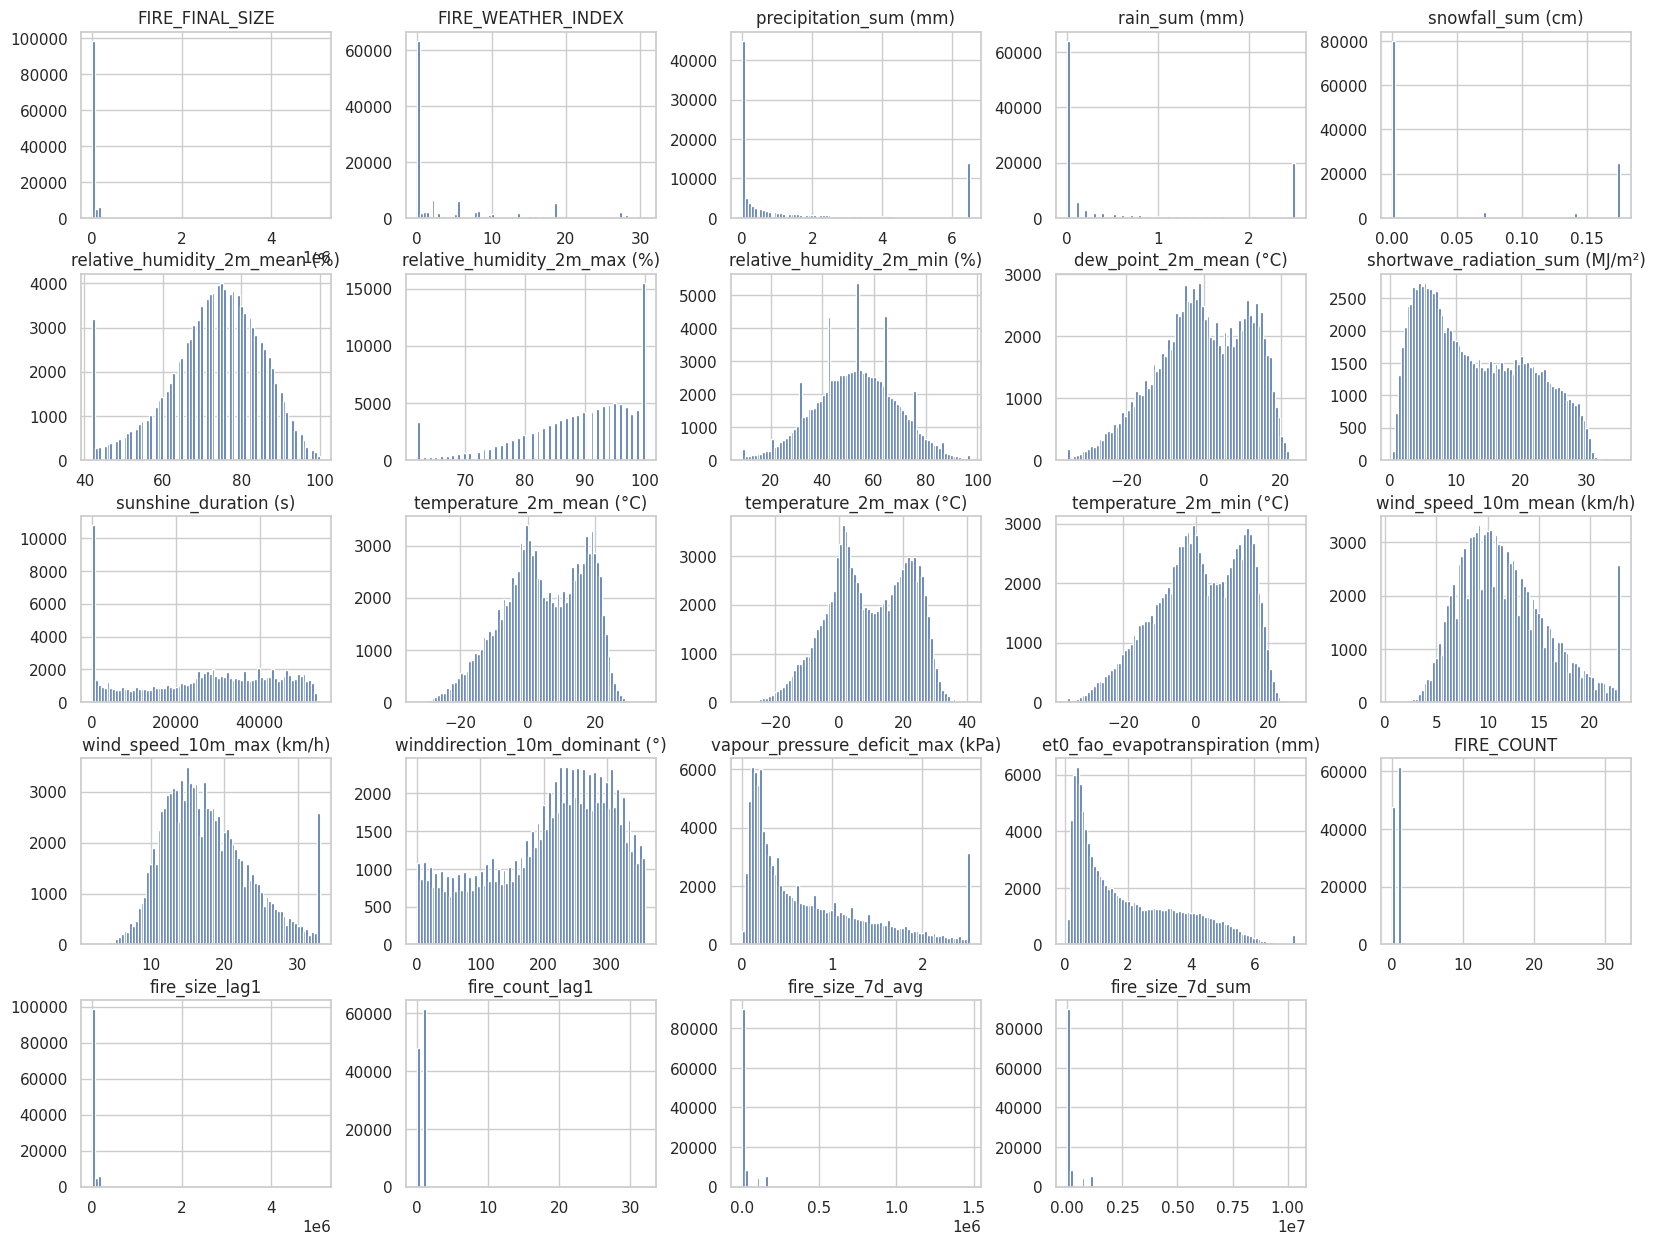

In [2509]:
X_train[numeric_cols].hist(figsize=(20,15),bins=80)
plt.show()

In [2510]:
X_train[numeric_cols].skew().sort_values()

relative_humidity_2m_max (%)         -0.964233
relative_humidity_2m_mean (%)        -0.552888
winddirection_10m_dominant (°)       -0.514862
temperature_2m_min (°C)              -0.365179
dew_point_2m_mean (°C)               -0.343351
temperature_2m_mean (°C)             -0.276701
sunshine_duration (s)                -0.265579
temperature_2m_max (°C)              -0.187362
relative_humidity_2m_min (%)         -0.056888
shortwave_radiation_sum (MJ/m²)       0.372122
wind_speed_10m_max (km/h)             0.615012
wind_speed_10m_mean (km/h)            0.635308
et0_fao_evapotranspiration (mm)       0.811821
vapour_pressure_deficit_max (kPa)     1.081320
snowfall_sum (cm)                     1.143697
rain_sum (mm)                         1.199628
precipitation_sum (mm)                1.222898
FIRE_WEATHER_INDEX                    1.966852
fire_size_7d_sum                      6.444525
fire_size_7d_avg                      6.444525
fire_count_lag1                       8.564602
FIRE_COUNT                            8.565398
fire_size_lag1                       28.743039
FIRE_FINAL_SIZE                      28.744150
dtype: float64

Skewness Handling:

 Weather variables often include long-tail distributions caused by natural
climate variability or sensor noise. To stabilize the model and improve
regression performance, we apply log-based transformations (log1p) to reduce right skewness.

Fire-related features (fire size, fire count, lag values) are intentionally left skewed because extreme fire events are real phenomena that strongly influence PM levels. Transforming them would remove valuable information.

In [2511]:
num_cols2=X_train.select_dtypes(include='number').columns

X_train[num_cols2].skew().sort_values()

lon                                  -1.151157
relative_humidity_2m_max (%)         -0.964233
relative_humidity_2m_mean (%)        -0.552888
winddirection_10m_dominant (°)       -0.514862
temperature_2m_min (°C)              -0.365179
dew_point_2m_mean (°C)               -0.343351
temperature_2m_mean (°C)             -0.276701
sunshine_duration (s)                -0.265579
FIRE_YEAR                            -0.263739
temperature_2m_max (°C)              -0.187362
relative_humidity_2m_min (%)         -0.056888
year                                  0.062754
shortwave_radiation_sum (MJ/m²)       0.372122
wind_speed_10m_max (km/h)             0.615012
wind_speed_10m_mean (km/h)            0.635308
et0_fao_evapotranspiration (mm)       0.811821
lat                                   0.824741
vapour_pressure_deficit_max (kPa)     1.081320
snowfall_sum (cm)                     1.143697
rain_sum (mm)                         1.199628
precipitation_sum (mm)                1.222898
FIRE_WEATHER_INDEX                    1.966852
fire_size_7d_sum                      6.444525
fire_size_7d_avg                      6.444525
fire_count_lag1                       8.564602
FIRE_COUNT                            8.565398
fire_size_lag1                       28.743039
FIRE_FINAL_SIZE                      28.744150
dtype: float64

In [2512]:
skewed=X_train[num_cols2].skew().sort_values()
skewed=skewed[abs(skewed)>0.75]

In [2513]:
'''X_train[skewed.index]=np.log1p(X_train[skewed.index])
X_test[skewed.index]=np.log1p(X_test[skewed.index])'''

'X_train[skewed.index]=np.log1p(X_train[skewed.index])\nX_test[skewed.index]=np.log1p(X_test[skewed.index])'

In [2514]:
X_train[num_cols2].skew().sort_values()

lon                                  -1.151157
relative_humidity_2m_max (%)         -0.964233
relative_humidity_2m_mean (%)        -0.552888
winddirection_10m_dominant (°)       -0.514862
temperature_2m_min (°C)              -0.365179
dew_point_2m_mean (°C)               -0.343351
temperature_2m_mean (°C)             -0.276701
sunshine_duration (s)                -0.265579
FIRE_YEAR                            -0.263739
temperature_2m_max (°C)              -0.187362
relative_humidity_2m_min (%)         -0.056888
year                                  0.062754
shortwave_radiation_sum (MJ/m²)       0.372122
wind_speed_10m_max (km/h)             0.615012
wind_speed_10m_mean (km/h)            0.635308
et0_fao_evapotranspiration (mm)       0.811821
lat                                   0.824741
vapour_pressure_deficit_max (kPa)     1.081320
snowfall_sum (cm)                     1.143697
rain_sum (mm)                         1.199628
precipitation_sum (mm)                1.222898
FIRE_WEATHER_INDEX                    1.966852
fire_size_7d_sum                      6.444525
fire_size_7d_avg                      6.444525
fire_count_lag1                       8.564602
FIRE_COUNT                            8.565398
fire_size_lag1                       28.743039
FIRE_FINAL_SIZE                      28.744150
dtype: float64

In [2515]:
pt = PowerTransformer(method='yeo-johnson')
X_train[skewed.index]= pt.fit_transform(X_train[skewed.index])
X_test[skewed.index]=pt.transform(X_test[skewed.index])

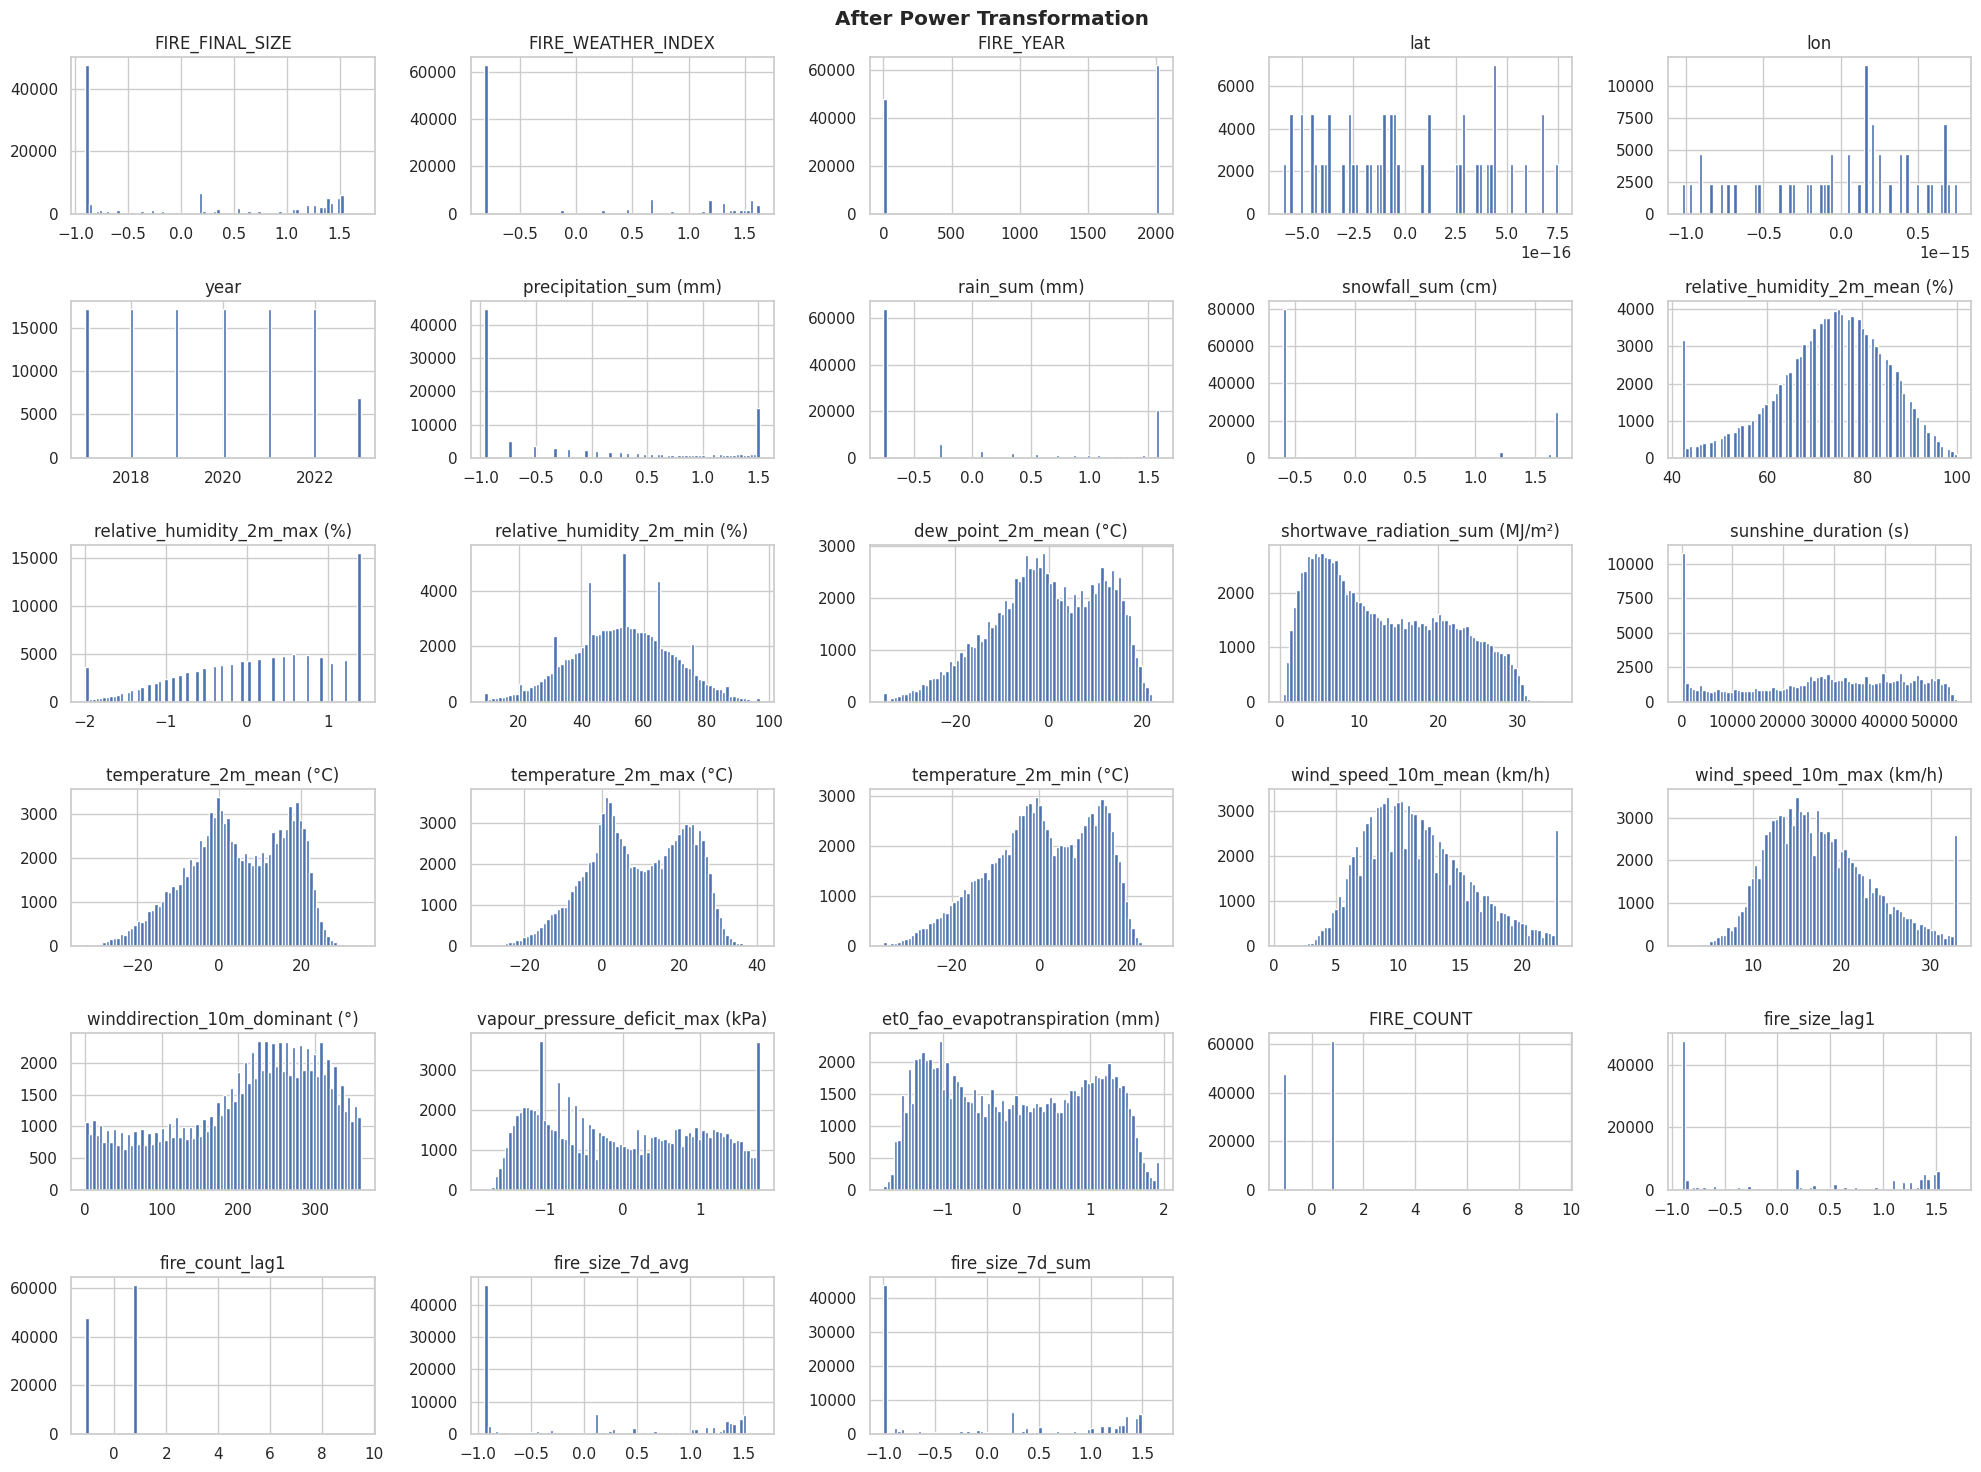

In [2516]:
X_train[num_cols2].hist(figsize=(20,15),bins=80)
plt.suptitle('After Power Transformation',weight='bold')
plt.tight_layout()
plt.show()

In [2517]:
X_train[num_cols2].skew().sort_values()

relative_humidity_2m_mean (%)       -0.552888
winddirection_10m_dominant (°)      -0.514862
temperature_2m_min (°C)             -0.365179
dew_point_2m_mean (°C)              -0.343351
temperature_2m_mean (°C)            -0.276701
sunshine_duration (s)               -0.265579
FIRE_YEAR                           -0.263739
relative_humidity_2m_max (%)        -0.201950
temperature_2m_max (°C)             -0.187362
relative_humidity_2m_min (%)        -0.056888
FIRE_COUNT                          -0.003937
fire_count_lag1                     -0.003835
lon                                  0.000000
lat                                  0.000000
et0_fao_evapotranspiration (mm)      0.057329
year                                 0.062754
vapour_pressure_deficit_max (kPa)    0.172538
fire_size_7d_sum                     0.293205
shortwave_radiation_sum (MJ/m²)      0.372122
precipitation_sum (mm)               0.396263
fire_size_7d_avg                     0.414289
FIRE_FINAL_SIZE                      0.455940
fire_size_lag1                       0.457065
FIRE_WEATHER_INDEX                   0.529980
wind_speed_10m_max (km/h)            0.615012
wind_speed_10m_mean (km/h)           0.635308
rain_sum (mm)                        0.741192
snowfall_sum (cm)                    1.051601
dtype: float64

**Feature extraction**

In [2518]:
X_train['month']=X_train['date'].dt.month
X_test['month']=X_test['date'].dt.month

In [2519]:
X_train['is_active']=(X_train['FIRE_COUNT']>=1).astype(int)
X_test['is_active']=(X_test['FIRE_COUNT']>=1).astype(int)
X_train.value_counts('is_active')

is_active
0    109170
1       698
Name: count, dtype: int64

that is True if there is at least one fire (FIRE_COUNT >= 1) on that day in that city, otherwise False.

It captures the presence of fire without relying on actual fire size or other numerical variables. This is helpful for the model to understand whether PM2.5 levels could be elevated due to fire activity on that day.

In [2520]:
X_train['wind_dryness_index'] =X_train['wind_speed_10m_mean (km/h)'] * (100-X_train['relative_humidity_2m_mean (%)'])
X_test['wind_dryness_index'] =X_test['wind_speed_10m_mean (km/h)'] * (100-X_test['relative_humidity_2m_mean (%)'])

In [2521]:
X_train['wind_dryness_index']

0         220.0
1         214.2
2         255.6
3         208.8
4         219.2
          ...  
109863    384.0
109864    596.7
109865    123.9
109866    676.8
109867    481.6
Name: wind_dryness_index, Length: 109868, dtype: float64

High wind speed + low relative humidity → higher dryness index → conditions more favorable for fire spread.

Low wind speed or high humidity → lower index → less risk.

It captures a fire weather factor that affects PM2.5 indirectly through fire activity.

In [2522]:
X_train['fire_weather_risk'] = ((X_train['temperature_2m_max (°C)'] / 30) + (X_train['wind_speed_10m_max (km/h)'] / 20) - (X_train['relative_humidity_2m_min (%)'] / 100) +(X_train['precipitation_sum (mm)'] * -0.5))
X_test['fire_weather_risk']=((X_test['temperature_2m_max (°C)'] / 30) + (X_test['wind_speed_10m_max (km/h)'] / 20) - (X_test['relative_humidity_2m_min (%)'] / 100) +(X_test['precipitation_sum (mm)'] * -0.5))

In [2523]:
X_train['fire_weather_risk']

0        -0.128734
1        -0.260458
2        -0.028885
3         0.610654
4         0.062730
            ...   
109863    0.333521
109864    1.860654
109865   -0.580830
109866    1.733987
109867    1.840654
Name: fire_weather_risk, Length: 109868, dtype: float64

Creates a composite index that estimates fire risk based on weather conditions.
Instead of handling these factors individually, it summarizes the weather conditions into one single numeric index that relates to potential fire activity and consequently PM2.5 levels.
Note:The division ensures that each component contributes proportionally to the final index

In [2524]:
X_train['temp_range'] = X_train['temperature_2m_max (°C)'] - X_train['temperature_2m_min (°C)']
X_train['inversion_risk'] = (X_train['temp_range'] < 5 ).astype(int)

X_test['temp_range'] = X_test['temperature_2m_max (°C)'] - X_test['temperature_2m_min (°C)']
X_test['inversion_risk'] = (X_test['temp_range'] < 5 ).astype(int)

these features capture atmospheric stability effects, which are relevant for predicting PM2.5 concentrations near wildfires.

In [2525]:
X_train['temp_range']

0          5.2
1          4.0
2          6.9
3          8.7
4          6.8
          ... 
109863     9.2
109864    15.9
109865     6.2
109866    10.6
109867    13.5
Name: temp_range, Length: 109868, dtype: float64

This calculates the daily temperature range (max − min).

Small ranges often indicate stable air, which can trap smoke near the surface, affecting air quality.

Large ranges usually mean strong heating/cooling, which enhances vertical mixing and reduces smoke accumulation.

In [2526]:
X_train['inversion_risk']

0         0
1         1
2         0
3         0
4         0
         ..
109863    0
109864    0
109865    0
109866    0
109867    0
Name: inversion_risk, Length: 109868, dtype: int64

This creates a binary indicator for potential temperature inversions.

If the daily temperature range is less than 5°C, it flags a likely inversion (1), otherwise 0.

Useful for wildfire/air quality modeling because inversions can trap pollutants, making PM2.5 worse.

In [2527]:
train=X_train[weather_features].copy()
test=X_test[weather_features].copy()

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10).fit(train_scaled)
X_train['weather_cluster'] = kmeans.predict(train_scaled)
X_test['weather_cluster'] = kmeans.predict(test_scaled)

Groups days with similar weather (temperature, humidity, wind, precipitation) into clusters

In [2528]:
X_train['weather_cluster']

0         3
1         3
2         3
3         1
4         3
         ..
109863    2
109864    2
109865    1
109866    2
109867    2
Name: weather_cluster, Length: 109868, dtype: int32

In [2529]:
temp_train_for_scaling = X_train[weather_features].copy()
temp_test_for_scaling = X_test[weather_features].copy()

fresh_scaler = StandardScaler()
train_scaled_re = fresh_scaler.fit_transform(temp_train_for_scaling)
test_scaled_re = fresh_scaler.transform(temp_test_for_scaling)

tr_distances = kmeans.transform(train_scaled_re)
ts_distances = kmeans.transform(test_scaled_re)
for i in range(4):
    X_train[f'distance_to_cluster_{i}'] = tr_distances[:, i]
    X_test[f'distance_to_cluster_{i}'] = ts_distances[:, i]

Provides more fine-grained information than just the cluster label.

If a day is near a cluster associated with high PM2.5 or high wildfire risk, the model can use that distance as a predictive signal.

These features encode weather patterns that might influence PM2.5 or fire activity without explicitly using all raw weather variables.

In [2530]:

'''train_stations = X_train[['city', 'lat', 'lon']].drop_duplicates()
coords = train_stations[['lat', 'lon']].values
kdtree = KDTree(coords)


G = nx.Graph()
for idx, station in train_stations.iterrows():
    G.add_node(station['city'], lat=station['lat'], lon=station['lon'])

radius_km = 150
radius_deg = radius_km / 111

for i, (lat, lon) in enumerate(coords):
    neighbors = kdtree.query_ball_point([lat, lon], radius_deg)
    for j in neighbors:
        if i != j:
            city_i = train_stations.iloc[i]['city']
            city_j = train_stations.iloc[j]['city']

            distance = geodesic((lat, lon), (coords[j][0], coords[j][1])).km
            G.add_edge(city_i, city_j, weight=distance)


degree_dict = dict(G.degree())
closeness_dict = nx.closeness_centrality(G)
betweenness_dict = nx.betweenness_centrality(G)

graph_features_train = []
for city in X_train['city'].unique():
    neighbors = list(G.neighbors(city))
    features = {
        'city': city,
        'degree_centrality': degree_dict.get(city, 0),
        'closeness_centrality': closeness_dict.get(city, 0),
        'betweenness_centrality': betweenness_dict.get(city, 0),
        'avg_neighbor_distance': np.mean([G[city][n]['weight'] for n in neighbors]) if neighbors else 0
    }
    graph_features_train.append(features)

graph_df_train = pd.DataFrame(graph_features_train)


new_cols = ['degree_centrality', 'closeness_centrality', 'betweenness_centrality', 'avg_neighbor_distance']

X_train = X_train.drop(columns=[c for c in new_cols if c in X_train.columns])
X_test = X_test.drop(columns=[c for c in new_cols if c in X_test.columns])


X_train = X_train.merge(graph_df_train, on='city', how='left')
X_test = X_test.merge(graph_df_train, on='city', how='left')

print("Graph features added successfully!")'''

'train_stations = X_train[[\'city\', \'lat\', \'lon\']].drop_duplicates()\ncoords = train_stations[[\'lat\', \'lon\']].values\nkdtree = KDTree(coords)\n\n\nG = nx.Graph()\nfor idx, station in train_stations.iterrows():\n    G.add_node(station[\'city\'], lat=station[\'lat\'], lon=station[\'lon\'])\n\nradius_km = 150\nradius_deg = radius_km / 111 \n\nfor i, (lat, lon) in enumerate(coords):\n    neighbors = kdtree.query_ball_point([lat, lon], radius_deg)\n    for j in neighbors:\n        if i != j:\n            city_i = train_stations.iloc[i][\'city\']\n            city_j = train_stations.iloc[j][\'city\']\n\n            distance = geodesic((lat, lon), (coords[j][0], coords[j][1])).km\n            G.add_edge(city_i, city_j, weight=distance)\n\n\ndegree_dict = dict(G.degree())\ncloseness_dict = nx.closeness_centrality(G)\nbetweenness_dict = nx.betweenness_centrality(G)\n\ngraph_features_train = []\nfor city in X_train[\'city\'].unique():\n    neighbors = list(G.neighbors(city))\n    featur

**Degree Centrality (degree_centrality)**

Counts how many neighboring cities each city has within the specified radius.

Higher degree → the city is more “connected” spatially, which can influence pollution spread or fire risk patterns.

**Closeness Centrality (closeness_centrality)**

Measures how close a city is to all other cities in the network.

Cities with high closeness can “affect” or be affected by neighboring areas faster, useful for modeling environmental propagation.

**Betweenness Centrality (betweenness_centrality)**

Indicates whether a city lies on paths connecting other cities.

High betweenness → city might act as a hub in the spatial network, important for understanding regional effects.

**Average Neighbor Distance (avg_neighbor_distance)**

The average distance to connected cities.

Gives a sense of spatial isolation or density; isolated cities might behave differently in terms of PM2.5 or wildfire spread.

**These features capture spatial relationships between cities, allowing the model to understand how proximity, connectivity, and geography influence PM2.5 levels or wildfire activity. It essentially adds a network-aware perspective beyond just the city’s local weather or fire history**

In [2531]:
'''pos = {city: (data['lat'], data['lon']) for city, data in G.nodes(data=True)}
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

edge_trace = go.Scatter(x=edge_x, y=edge_y,line=dict(width=0.5, color='#888'),hoverinfo='none',mode='lines')


node_x = []
node_y = []
node_text = []

for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(f"{node}<br>Degree: {G.degree(node)}<br>Neighbors: {list(G.neighbors(node))}")

node_trace = go.Scatter(x=node_x, y=node_y,mode='markers',hoverinfo='text',
    text=node_text,marker=dict(showscale=True, reversescale=True,
        color=[G.degree(n) for n in G.nodes()],
        size=[G.degree(n)*5 for n in G.nodes()],
        colorbar=dict(thickness=15,title='Node Degree',xanchor='left',titleside='right'),
        line_width=1))

fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(title='Interactive Spatial Graph of Cities',titlefont_size=16,
                    showlegend=False,hovermode='closest',margin=dict(b=20,l=5,r=5,t=40),
                    xaxis=dict(showgrid=True, zeroline=False, showticklabels=True),
                    yaxis=dict(showgrid=True, zeroline=False, showticklabels=True)))

fig.show()
'''

'pos = {city: (data[\'lat\'], data[\'lon\']) for city, data in G.nodes(data=True)}\nedge_x = []\nedge_y = []\nfor edge in G.edges():\n    x0, y0 = pos[edge[0]]\n    x1, y1 = pos[edge[1]]\n    edge_x.extend([x0, x1, None])\n    edge_y.extend([y0, y1, None])\n\nedge_trace = go.Scatter(x=edge_x, y=edge_y,line=dict(width=0.5, color=\'#888\'),hoverinfo=\'none\',mode=\'lines\')\n\n\nnode_x = []\nnode_y = []\nnode_text = []\n\nfor node in G.nodes():\n    x, y = pos[node]\n    node_x.append(x)\n    node_y.append(y)\n    node_text.append(f"{node}<br>Degree: {G.degree(node)}<br>Neighbors: {list(G.neighbors(node))}")\n\nnode_trace = go.Scatter(x=node_x, y=node_y,mode=\'markers\',hoverinfo=\'text\',\n    text=node_text,marker=dict(showscale=True, reversescale=True,\n        color=[G.degree(n) for n in G.nodes()],\n        size=[G.degree(n)*5 for n in G.nodes()],\n        colorbar=dict(thickness=15,title=\'Node Degree\',xanchor=\'left\',titleside=\'right\'),\n        line_width=1))\n\nfig = go.Figu

In [2532]:
num_col=X_train.select_dtypes(include='number').columns

**Studying the New Features**

<Figure size 1500x1200 with 0 Axes>

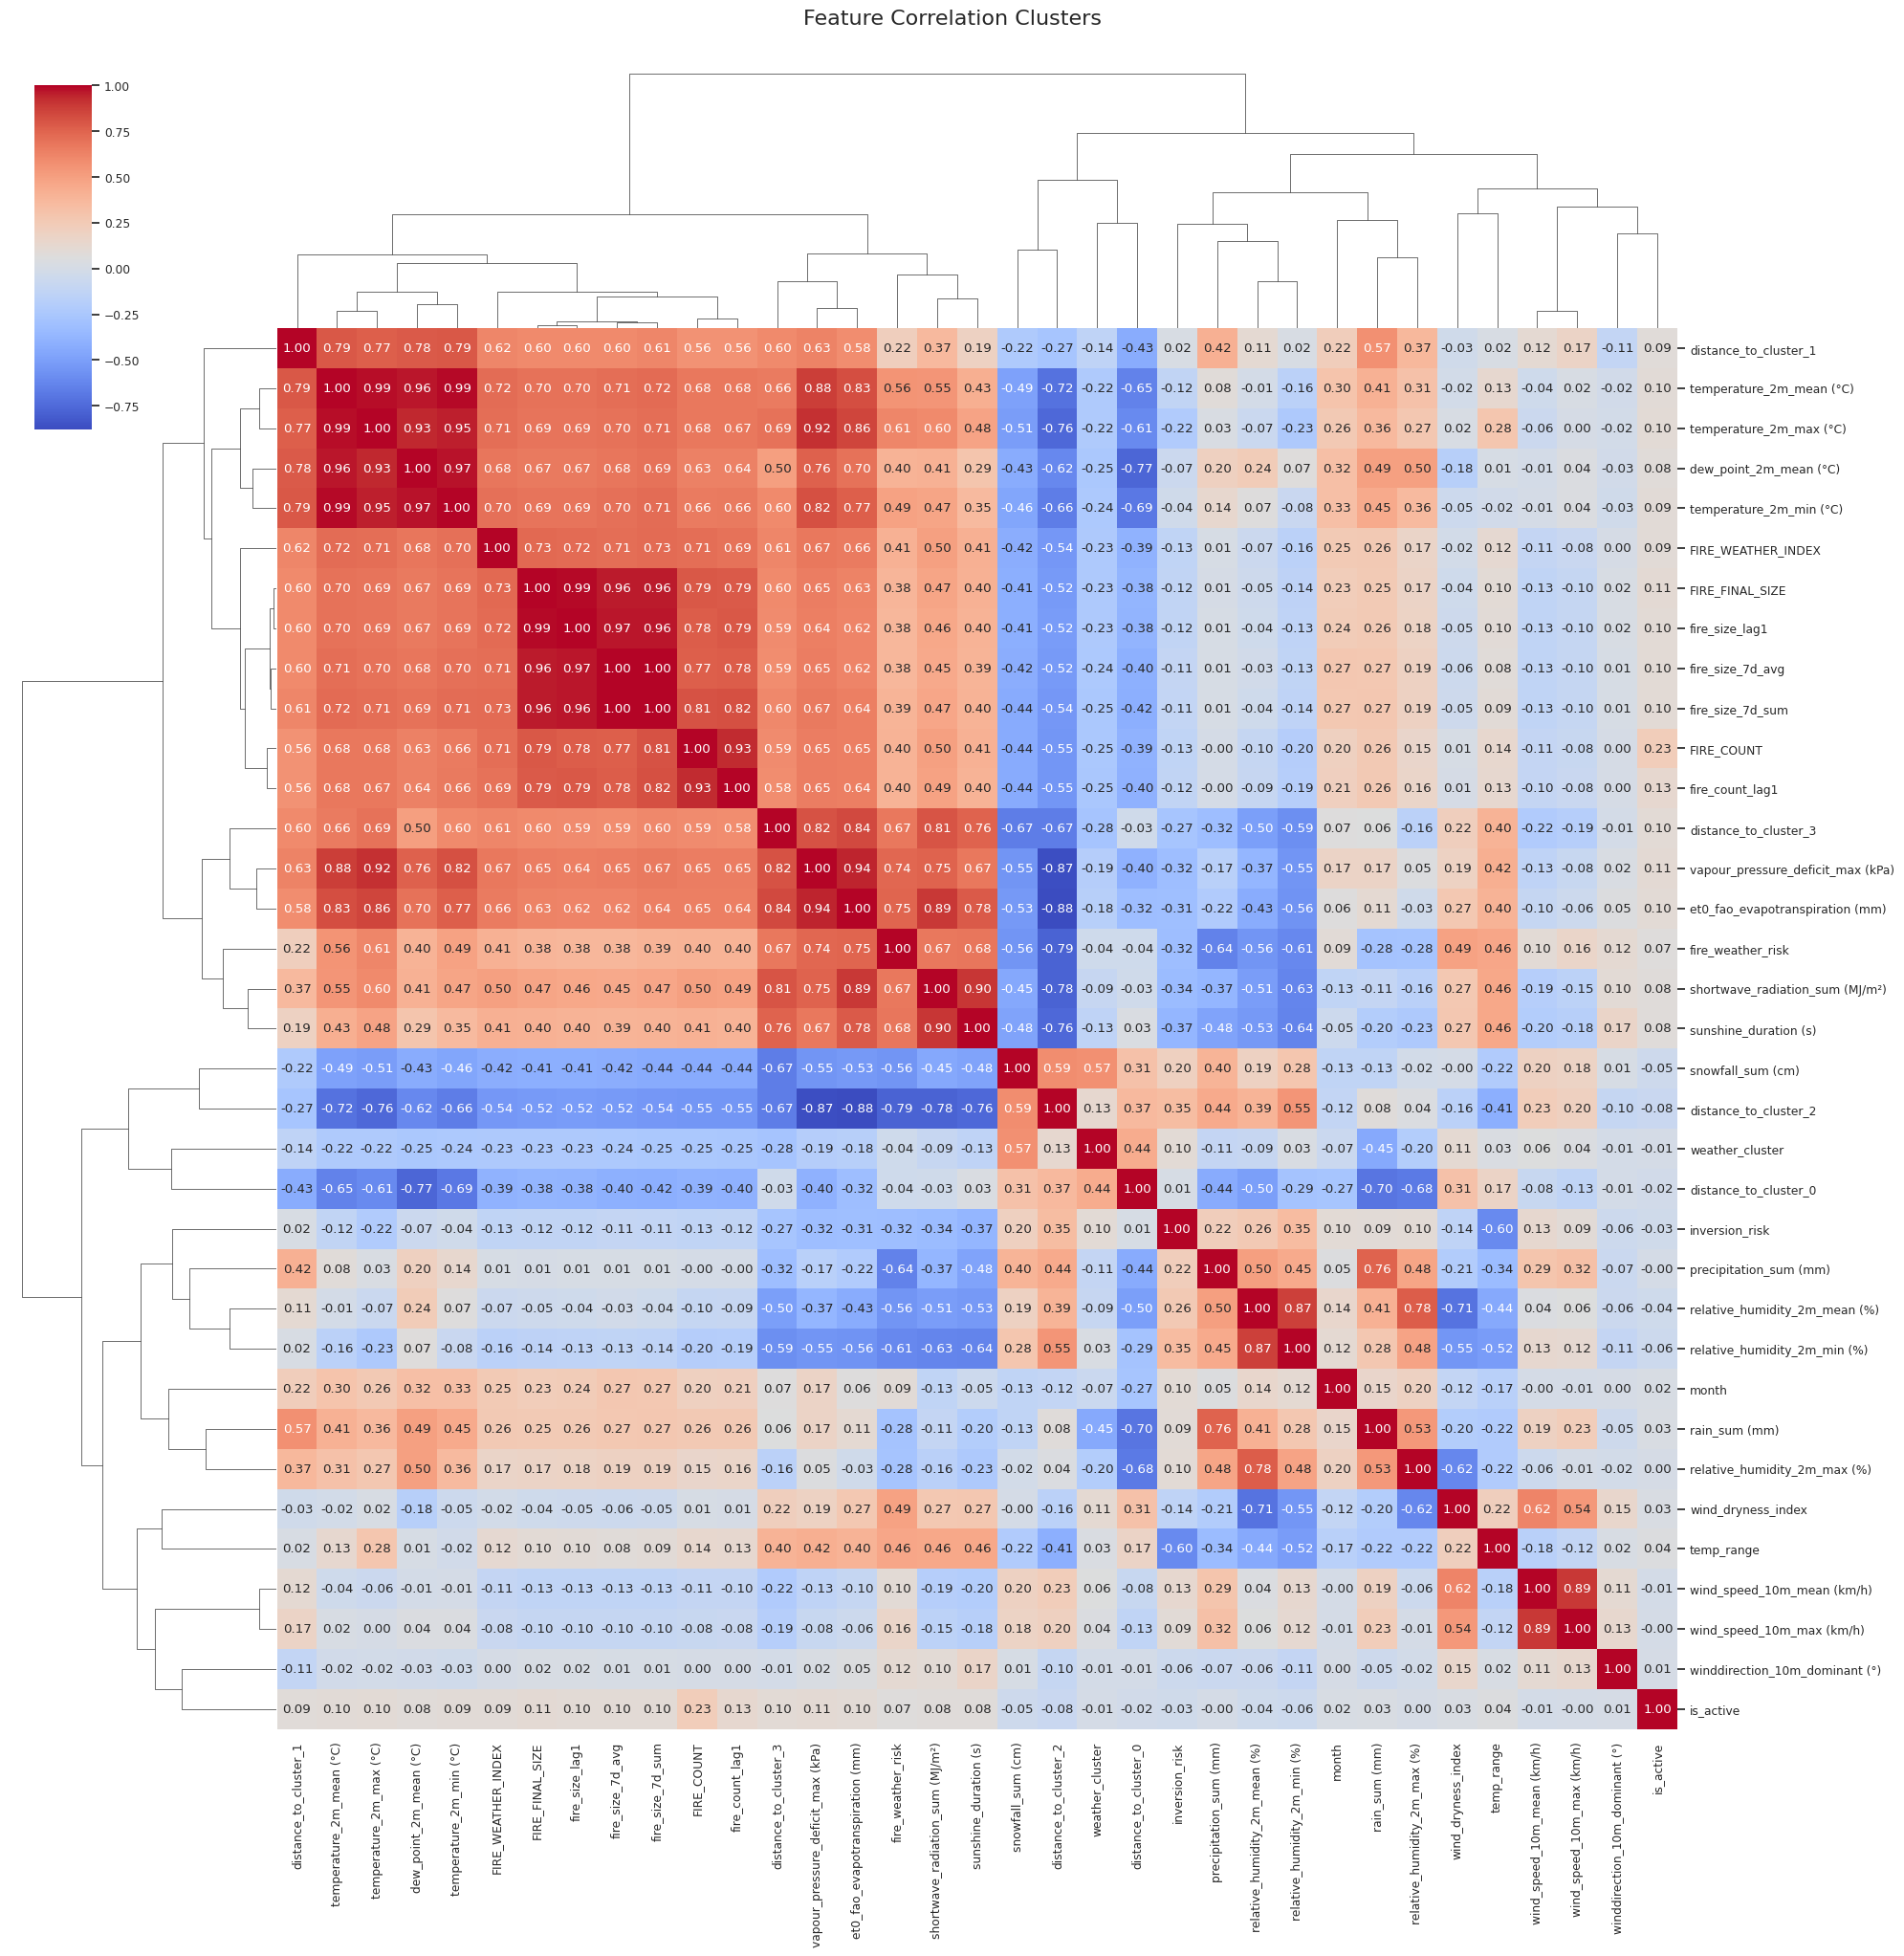

In [2533]:
plt.clf()
sns.set_theme(font_scale=0.8)

cols_for_correlation = X_train.select_dtypes(include='number').columns.drop(['lat', 'lon', 'year', 'FIRE_YEAR'], errors='ignore')

constant_columns = [col for col in cols_for_correlation if X_train[col].nunique() <= 1]
if constant_columns:
    print(f"Dropping constant columns for correlation: {constant_columns}")
    cols_for_correlation = cols_for_correlation.drop(constant_columns)


correlation_matrix = X_train[cols_for_correlation].corr()




g = sns.clustermap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    figsize=(20, 20),
    dendrogram_ratio=0.16,
    cbar_pos=(0.02, 0.8, 0.03, 0.18)
)

g.fig.suptitle("Feature Correlation Clusters", y=1.02, fontsize=16)

plt.show()

<Figure size 1500x1200 with 0 Axes>

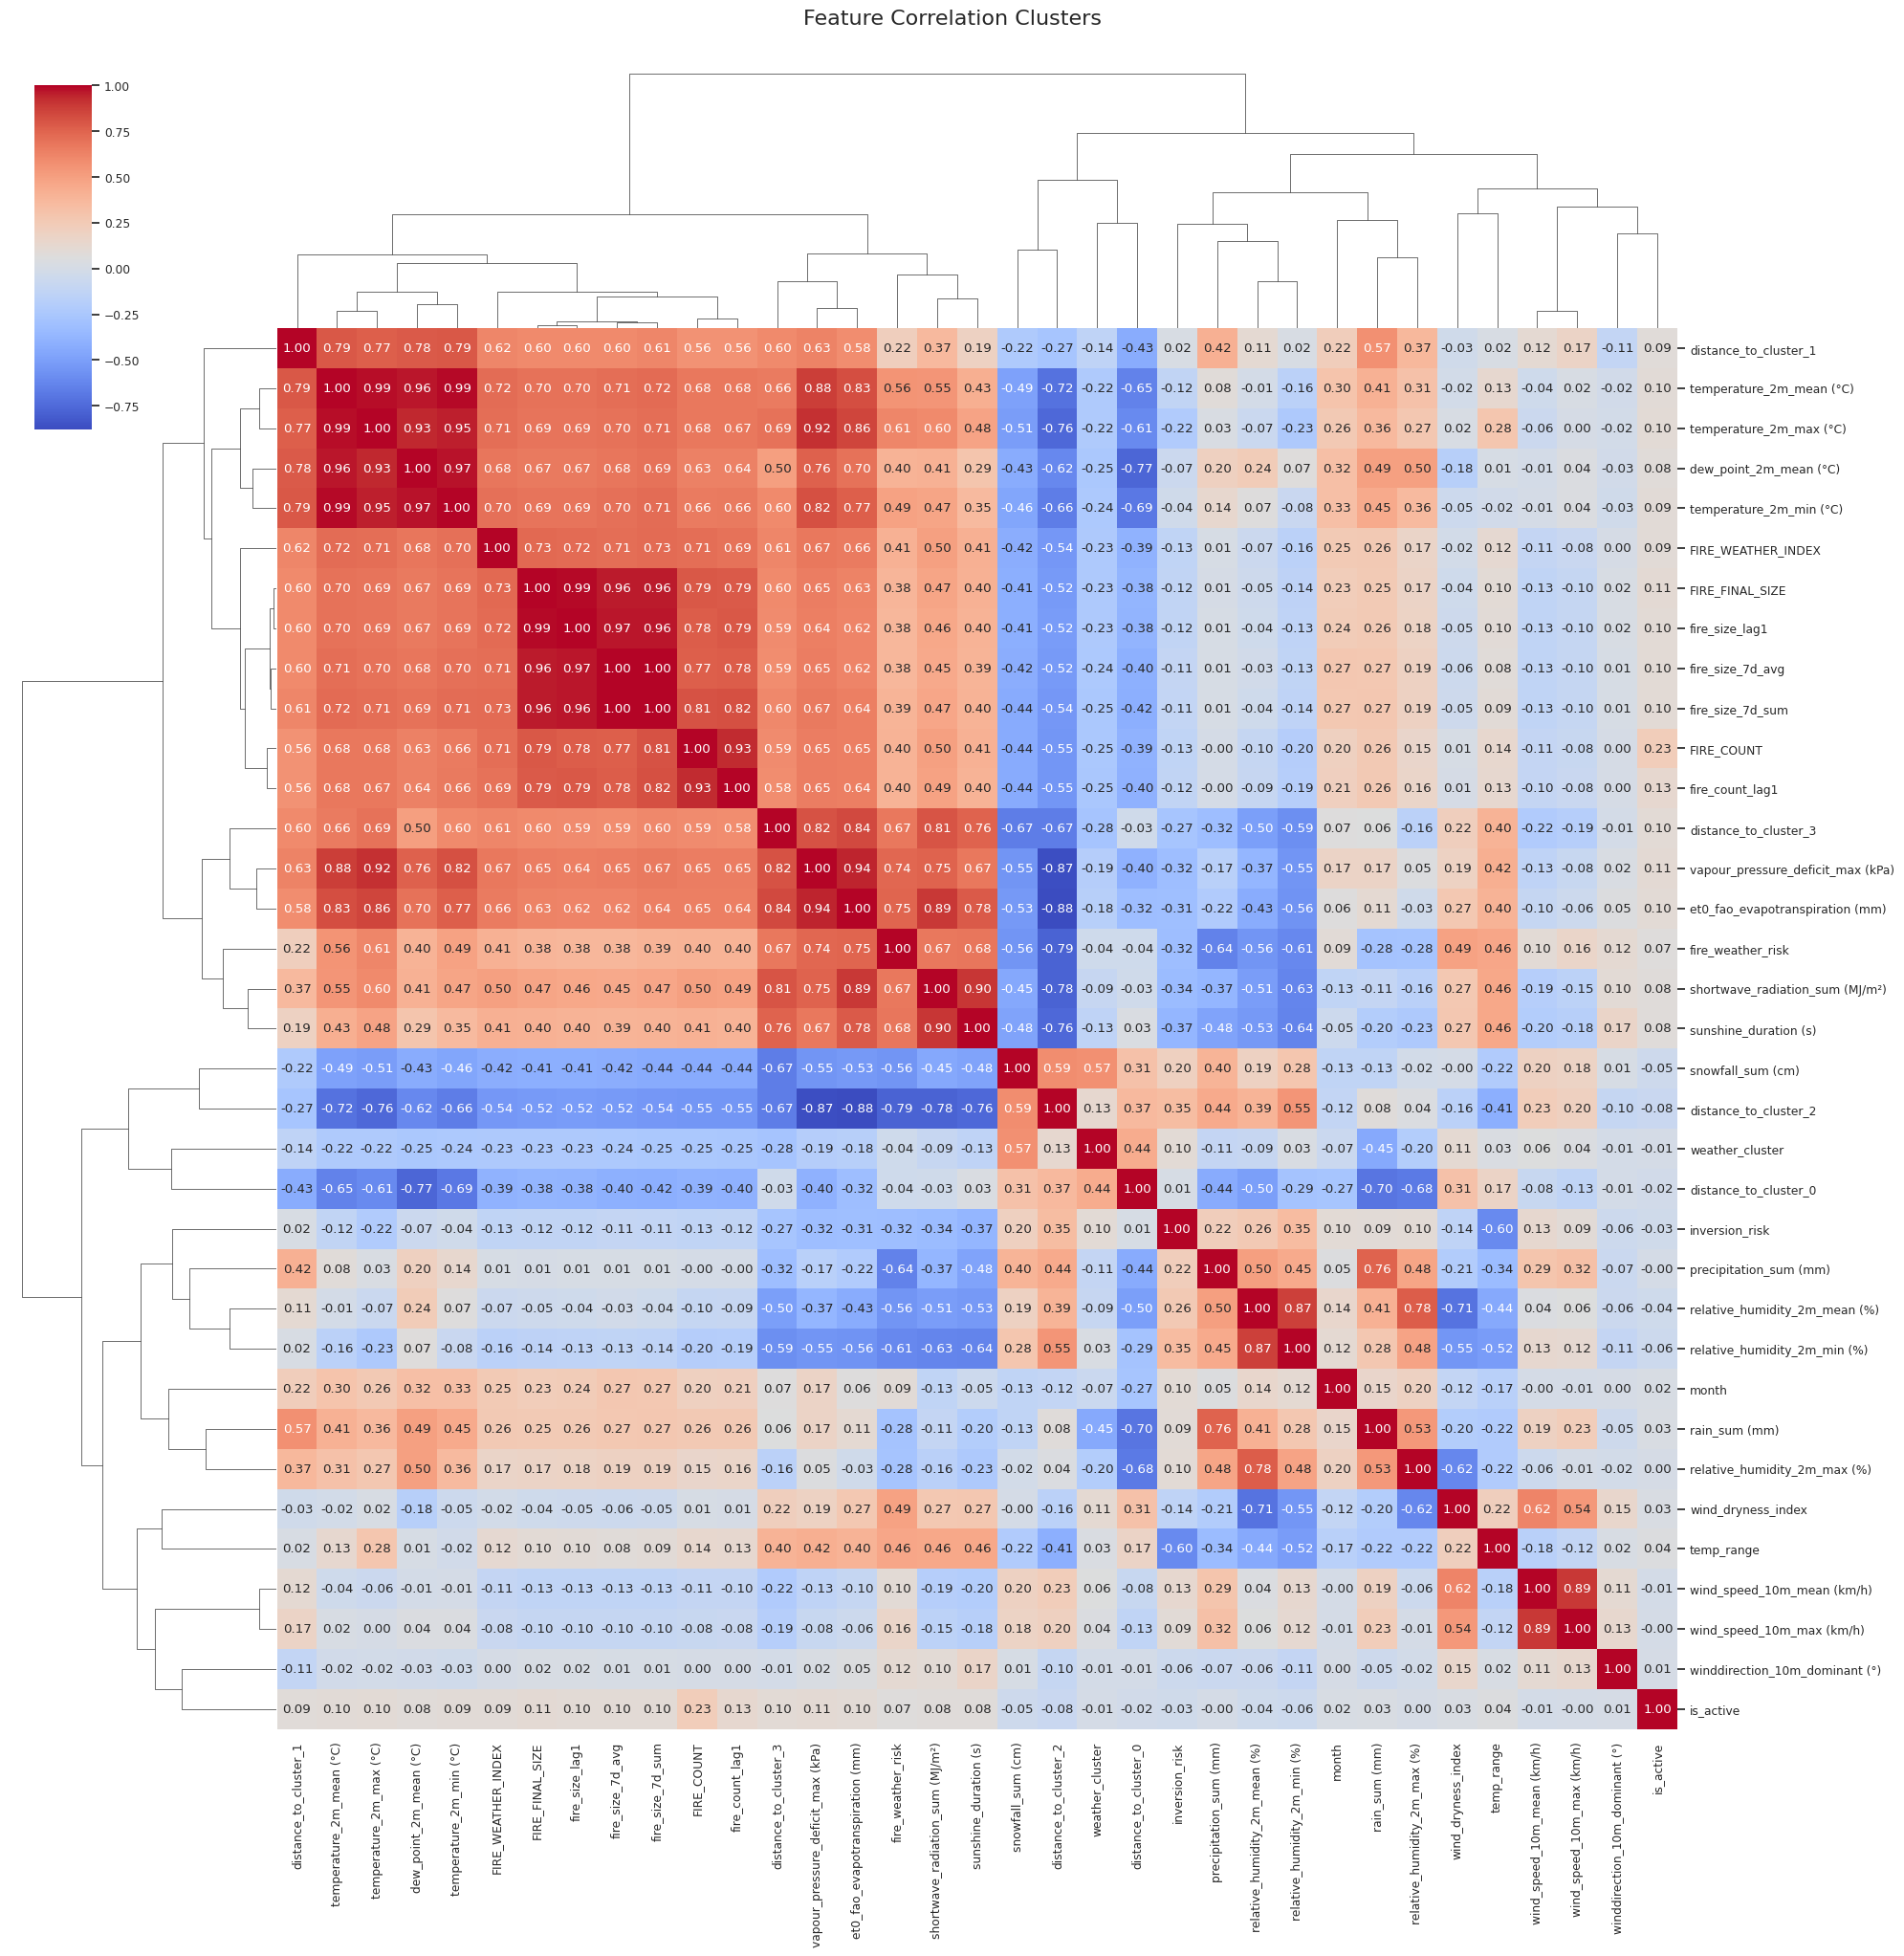

In [2534]:
plt.clf()
sns.set_theme(font_scale=0.8)

cols_for_correlation = X_train.select_dtypes(include='number').columns.drop(['lat', 'lon', 'year', 'FIRE_YEAR'], errors='ignore')

g = sns.clustermap(
    X_train[cols_for_correlation].corr(),
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    figsize=(20, 20),
    dendrogram_ratio=0.16,
    cbar_pos=(0.02, 0.8, 0.03, 0.18)
)

g.fig.suptitle("Feature Correlation Clusters", y=1.02, fontsize=16)

plt.show()

In [2535]:
new_features=['FIRE_COUNT', 'fire_size_lag1', 'fire_count_lag1', 'fire_size_7d_avg', 'fire_size_7d_sum', 'month', 'is_active',
              'wind_dryness_index', 'fire_weather_risk', 'temp_range', 'inversion_risk', 'weather_cluster', 'distance_to_cluster_0', 'distance_to_cluster_1',
              'distance_to_cluster_2', 'distance_to_cluster_3']

In [2536]:
X_train[new_features].isnull().sum().sum()
X_test[new_features].isnull().sum().sum()

np.int64(0)

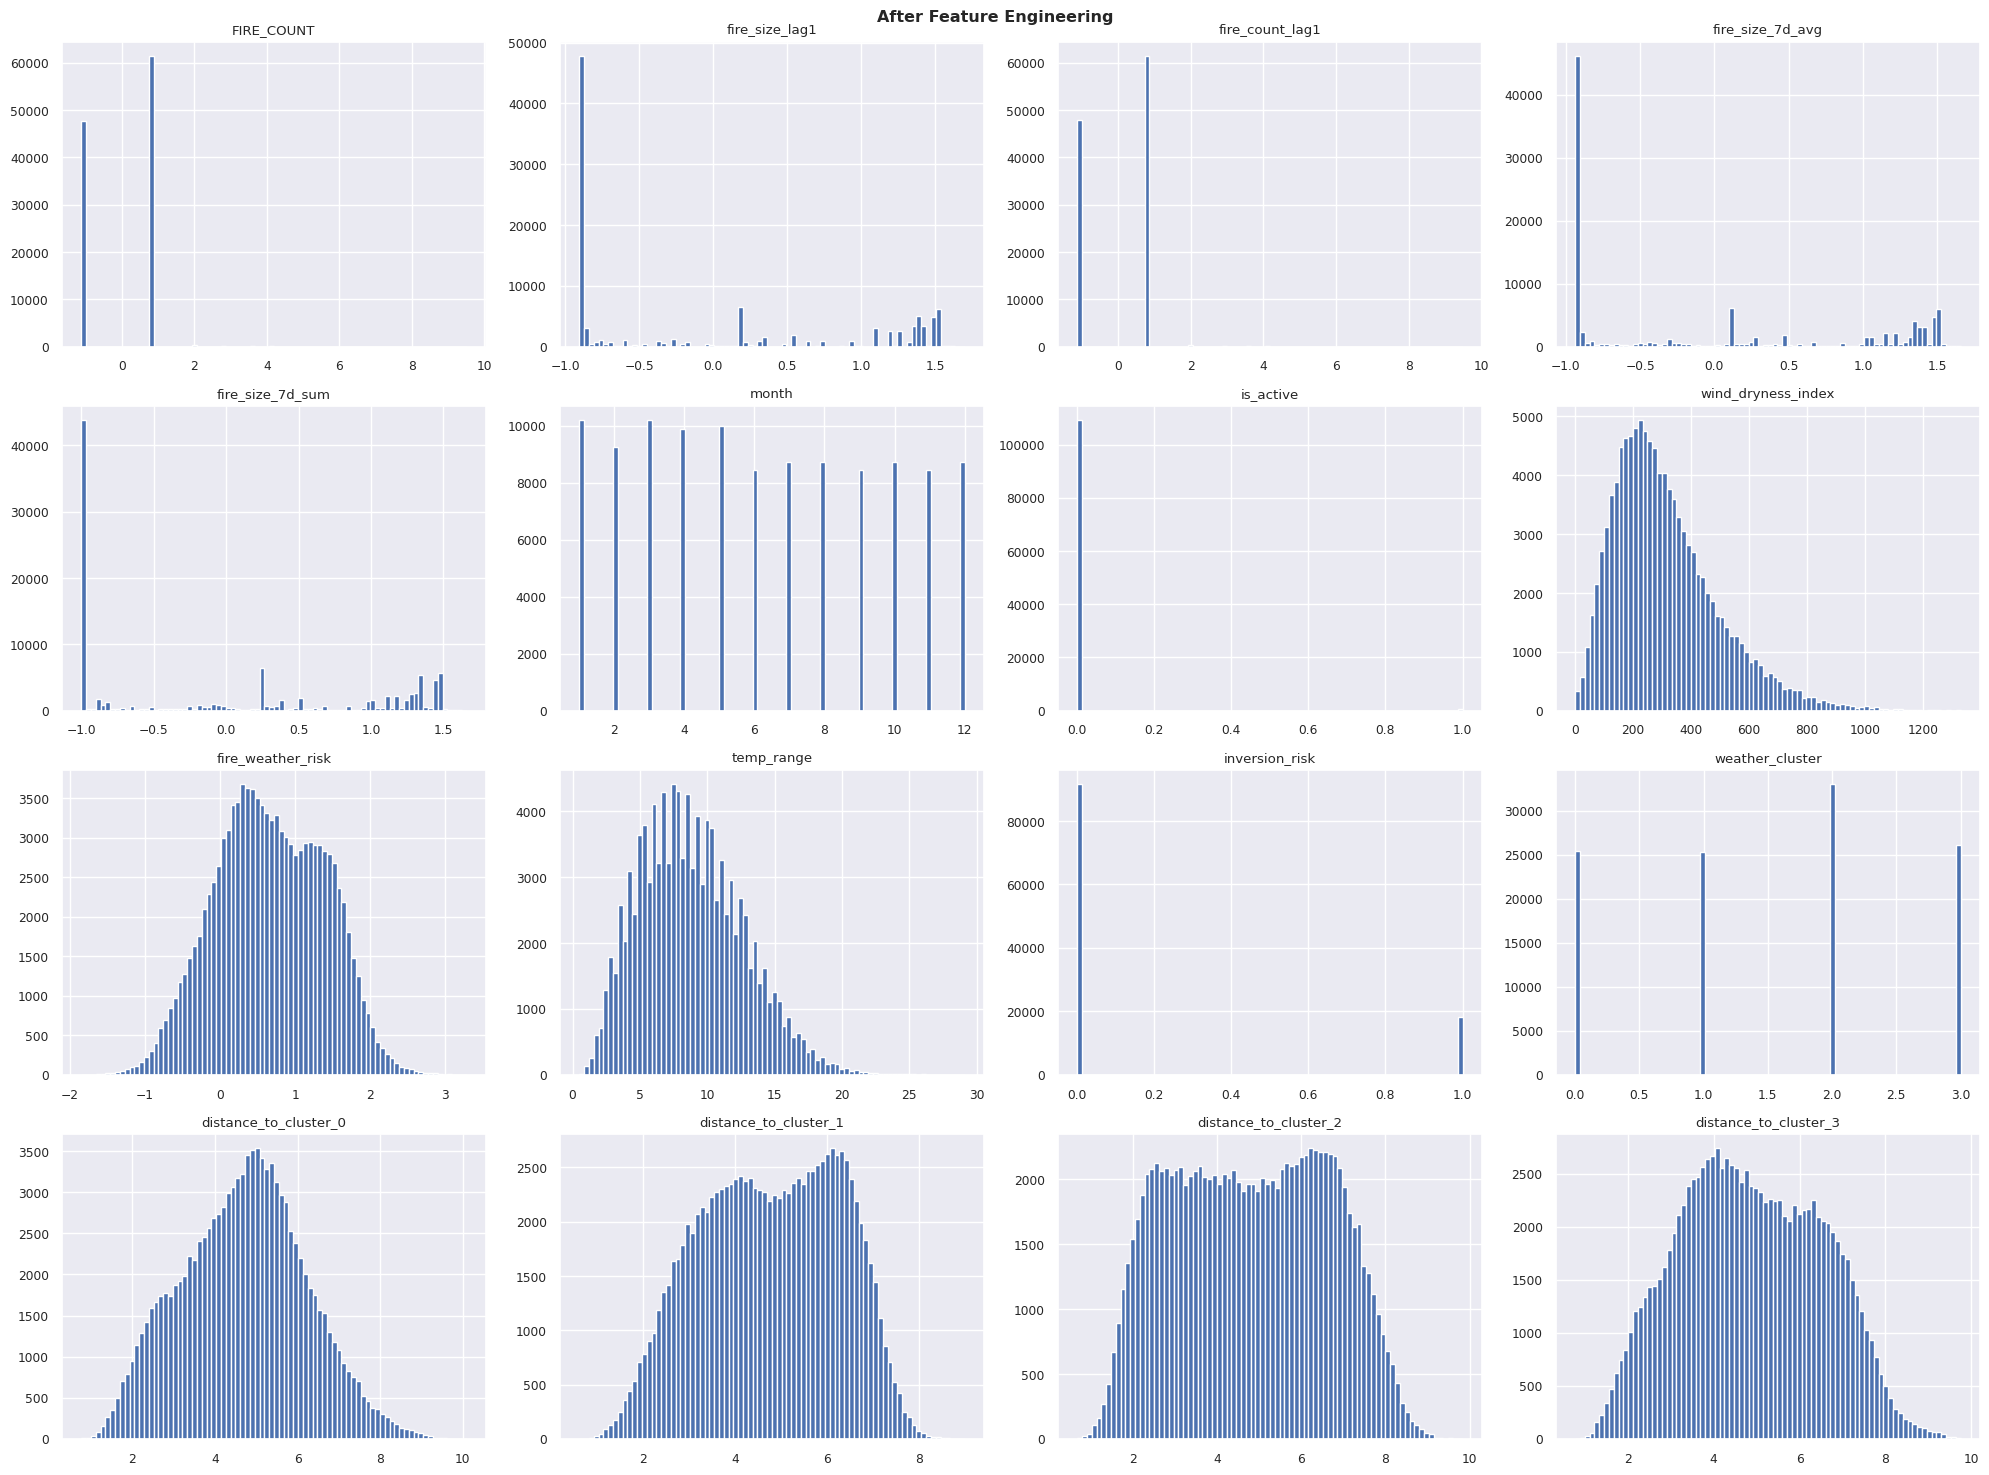

In [2537]:
X_train[new_features].hist(figsize=(20,15),bins=80)
plt.suptitle('After Feature Engineering',weight='bold')
plt.tight_layout()
plt.show()

In [2538]:
X_train[new_features].skew().sort_values()

distance_to_cluster_1    -0.124591
weather_cluster          -0.099942
fire_weather_risk        -0.013685
FIRE_COUNT               -0.003937
fire_count_lag1          -0.003835
distance_to_cluster_2     0.022081
distance_to_cluster_0     0.072682
month                     0.084995
distance_to_cluster_3     0.087692
fire_size_7d_sum          0.293205
fire_size_7d_avg          0.414289
fire_size_lag1            0.457065
temp_range                0.491123
wind_dryness_index        1.089782
inversion_risk            1.792871
is_active                12.426368
dtype: float64

In [2539]:
skewed=X_train[new_features].skew().sort_values()
skewed=skewed[abs(skewed)>0.75]
pt = PowerTransformer(method='yeo-johnson')
X_train[skewed.index]= pt.fit_transform(X_train[skewed.index])
X_test[skewed.index]=pt.transform(X_test[skewed.index])

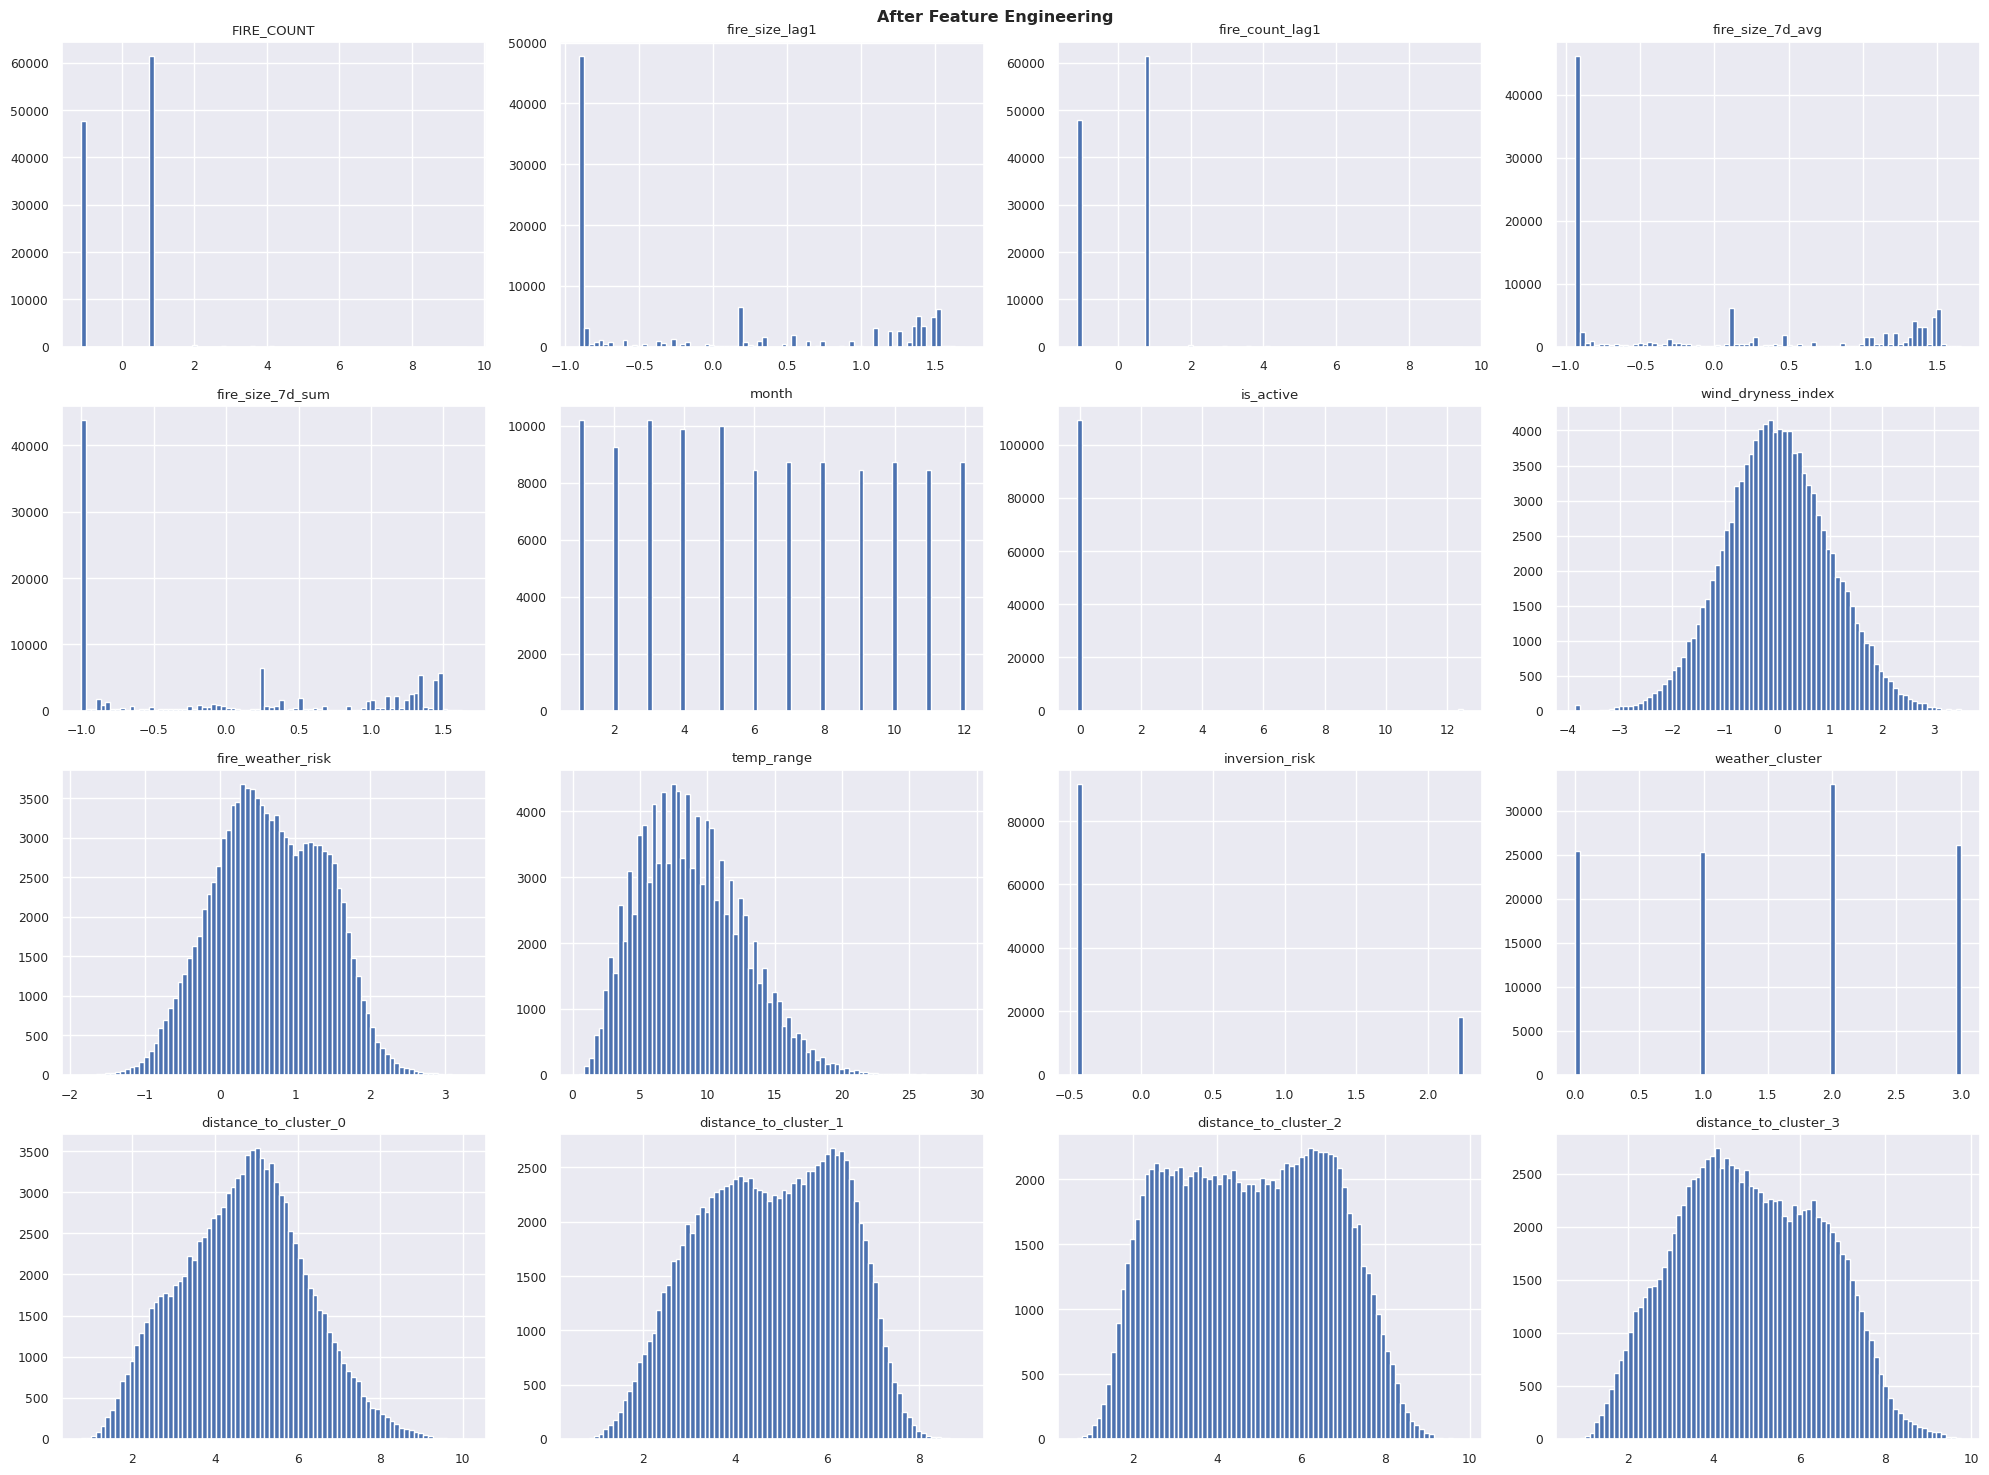

In [2540]:
X_train[new_features].hist(figsize=(20,15),bins=80)
plt.suptitle('After Feature Engineering',weight='bold')
plt.tight_layout()
plt.show()

In [2541]:
X_train[new_features].skew().sort_values()


distance_to_cluster_1    -0.124591
weather_cluster          -0.099942
fire_weather_risk        -0.013685
FIRE_COUNT               -0.003937
fire_count_lag1          -0.003835
wind_dryness_index        0.011581
distance_to_cluster_2     0.022081
distance_to_cluster_0     0.072682
month                     0.084995
distance_to_cluster_3     0.087692
fire_size_7d_sum          0.293205
fire_size_7d_avg          0.414289
fire_size_lag1            0.457065
temp_range                0.491123
inversion_risk            1.792871
is_active                12.426368
dtype: float64

In [2542]:
Q1=X_train[new_features].quantile(0.25)
Q3=X_train[new_features].quantile(0.75)
IQR=Q3-Q1
outliers=(X_train[new_features] < (Q1 - 1.5 * IQR)) | (X_train[new_features] > (Q3 + 1.5 * IQR))

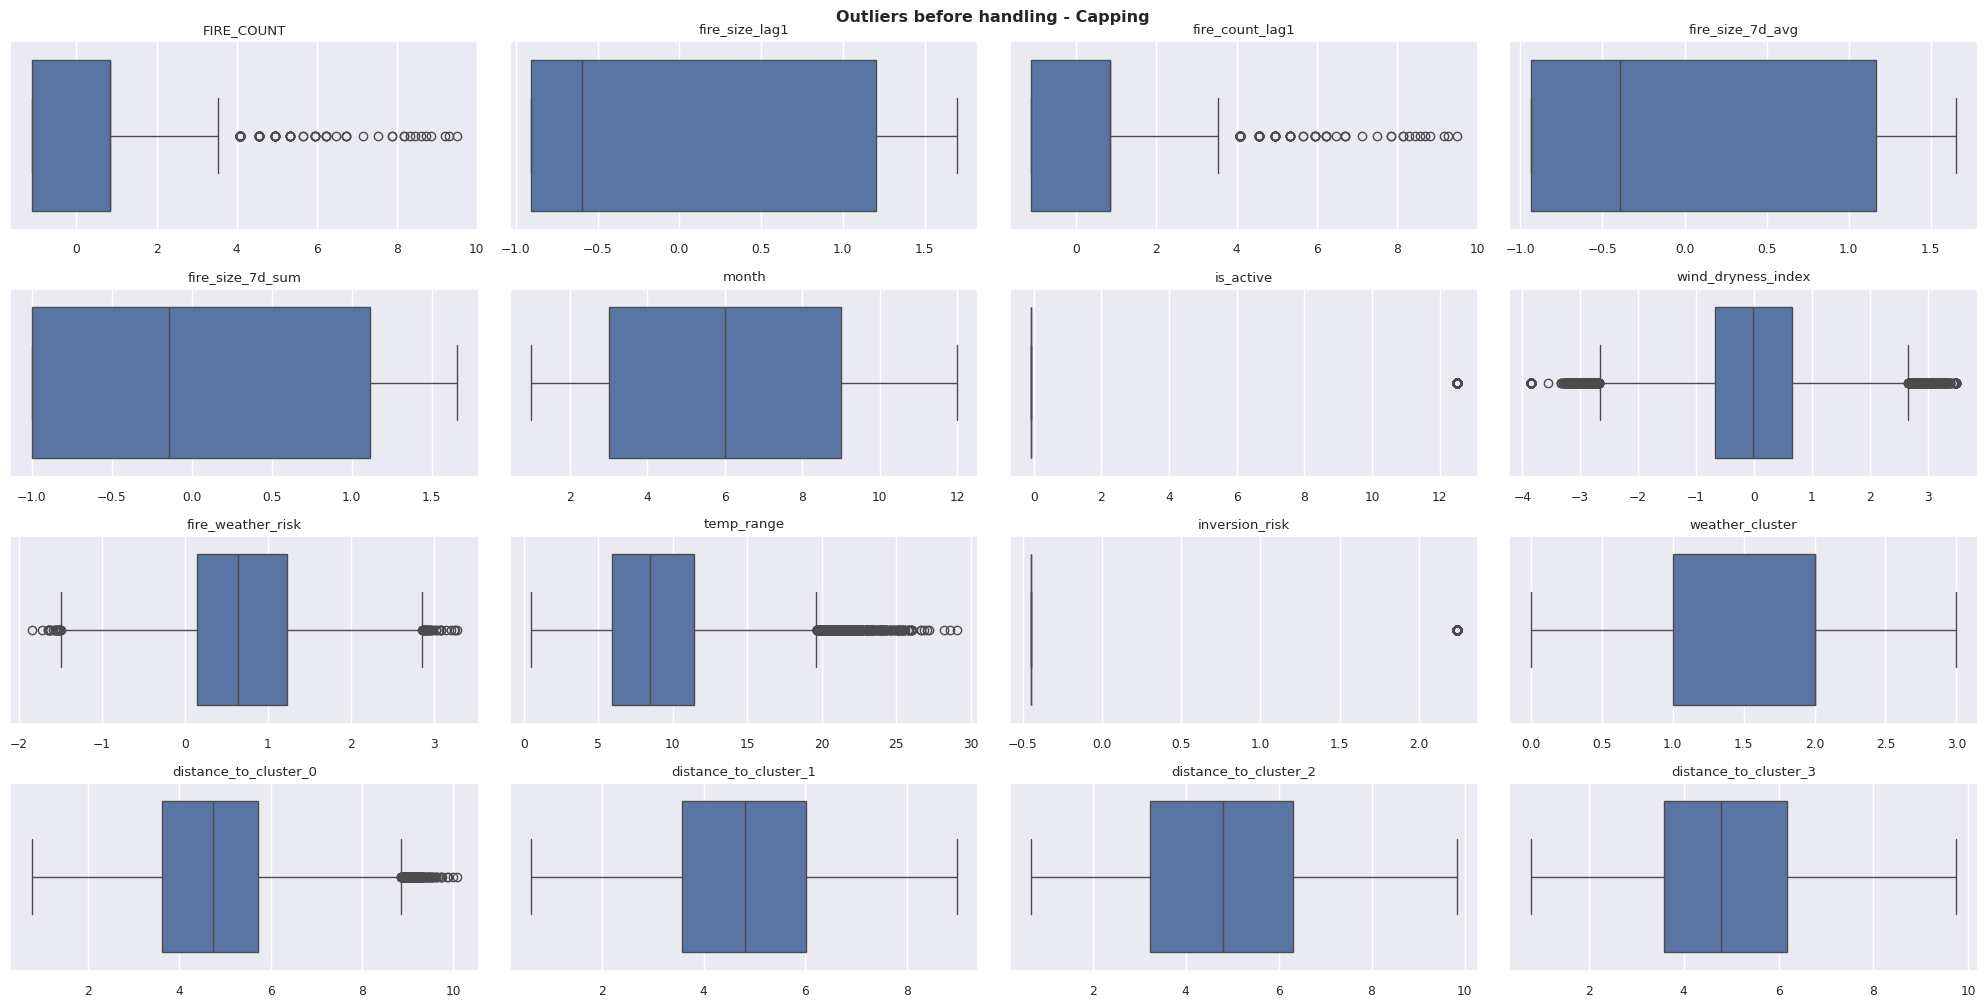

In [2543]:
fig,ax=plt.subplots(6,4,figsize=(20,15))
ax=ax.flatten()

for i,s in enumerate(new_features):
   Min=Q1[s]-1.5*IQR[s]
   Max=Q3[s]+1.5*IQR[s]
   sns.boxplot(x=X_train[s],ax=ax[i])
   ax[i].set_title(s)
   ax[i].set_xlabel('')

for j in range(len(new_features), len(ax)):
    fig.delaxes(ax[j])

plt.suptitle('Outliers before handling - Capping',weight='bold')
plt.tight_layout()
plt.show()

advanced

**Encoding**


In [2544]:
cat_cols = ['city', 'FIRE_TYPE_CODE', 'FIRE_GENERAL_CAUSE_CODE', 'FIRE_RESPONSE_OBJ_CODE']
le_dict = {}
for col in cat_cols:

    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)

    le = LabelEncoder()

    all_labels = pd.concat([X_train[col], X_test[col]]).unique()
    le.fit(all_labels)

    X_train[col] = le.transform(X_train[col])
    X_test[col] = le.transform(X_test[col])
    le_dict[col] = le

In [2545]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109868 entries, 0 to 109867
Data columns (total 46 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   date                               109868 non-null  datetime64[ns]
 1   city                               109868 non-null  int64         
 2   FIRE_FINAL_SIZE                    109868 non-null  float64       
 3   FIRE_WEATHER_INDEX                 109868 non-null  float64       
 4   FIRE_START_DATE                    109868 non-null  datetime64[ns]
 5   FIRE_OUT_DATE                      109868 non-null  datetime64[ns]
 6   FIRE_TYPE_CODE                     109868 non-null  int64         
 7   FIRE_GENERAL_CAUSE_CODE            109868 non-null  int64         
 8   FIRE_RESPONSE_OBJ_CODE             109868 non-null  int64         
 9   FIRE_YEAR                          109868 non-null  float64       
 10  lat                 

In [2546]:
X_train

date  city  FIRE_FINAL_SIZE  FIRE_WEATHER_INDEX FIRE_START_DATE  \
0      2017-01-01     0        -0.906802           -0.818949      1970-01-01   
1      2017-01-01     1        -0.906802           -0.818949      1970-01-01   
2      2017-01-01     2        -0.906802           -0.818949      1970-01-01   
3      2017-01-01     3        -0.906802           -0.818949      1970-01-01   
4      2017-01-01     4        -0.906802           -0.818949      1970-01-01   
...           ...   ...              ...                 ...             ...   
109863 2023-05-27    24         1.378156            1.500925      2023-05-25   
109864 2023-05-27    25         1.378156            1.500925      2023-05-25   
109865 2023-05-27    26         1.378156            1.500925      2023-05-25   
109866 2023-05-27    27         1.378156            1.500925      2023-05-25   
109867 2023-05-27    28         1.378156            1.500925      2023-05-25   

       FIRE_OUT_DATE  FIRE_TYPE_CODE  FIRE_GENERAL_CAUSE_CODE  \
0         1970-01-01               0                        5   
1         1970-01-01               0                        5   
2         1970-01-01               0                        5   
3         1970-01-01               0                        5   
4         1970-01-01               0                        5   
...              ...             ...                      ...   
109863    2023-10-06               1                        3   
109864    2023-10-06               1                        3   
109865    2023-10-06               1                        3   
109866    2023-10-06               1                        3   
109867    2023-10-06               1                        3   

        FIRE_RESPONSE_OBJ_CODE  FIRE_YEAR  ...  is_active  wind_dryness_index  \
0                            5        0.0  ...  -0.079961           -0.377586   
1                            5        0.0  ...  -0.079961           -0.417558   
2                            5        0.0  ...  -0.079961           -0.145486   
3                            5        0.0  ...  -0.079961           -0.455380   
4                            5        0.0  ...  -0.079961           -0.383061   
...                        ...        ...  ...        ...                 ...   
109863                       0     2023.0  ...  -0.079961            0.555360   
109864                       0     2023.0  ...  -0.079961            1.446982   
109865                       0     2023.0  ...  -0.079961           -1.152942   
109866                       0     2023.0  ...  -0.079961            1.730387   
109867                       0     2023.0  ...  -0.079961            0.994856   

        fire_weather_risk  temp_range  inversion_risk  weather_cluster  \
0               -0.128734         5.2       -0.446549                3   
1               -0.260458         4.0        2.239395                3   
2               -0.028885         6.9       -0.446549                3   
3                0.610654         8.7       -0.446549                1   
4                0.062730         6.8       -0.446549                3   
...                   ...         ...             ...              ...   
109863           0.333521         9.2       -0.446549                2   
109864           1.860654        15.9       -0.446549                2   
109865          -0.580830         6.2       -0.446549                1   
109866           1.733987        10.6       -0.446549                2   
109867           1.840654        13.5       -0.446549                2   

        distance_to_cluster_0  distance_to_cluster_1  distance_to_cluster_2  \
0                    4.552918               3.466390               5.766273   
1                    5.732136               3.132510               6.791413   
2                    4.744226               3.546036               6.141496   
3                    4.974902               2.256831               5.039125   
4             

**Scaling**

In [2547]:
date=X_train['date']

In [2548]:
X_train.drop(columns=['date', 'FIRE_START_DATE','lat','lon','FIRE_COUNT','FIRE_OUT_DATE'], inplace=True)
X_test.drop(columns=['date', 'FIRE_START_DATE','lat','lon','FIRE_COUNT','FIRE_OUT_DATE'], inplace=True)

In [2549]:
col=X_train.columns
scaler=RobustScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

X_train=pd.DataFrame(X_train,columns=col)
X_test=pd.DataFrame(X_test,columns=col)

In [2550]:
X_train['date']=date
X_test['date']=date

# Taget cleaning

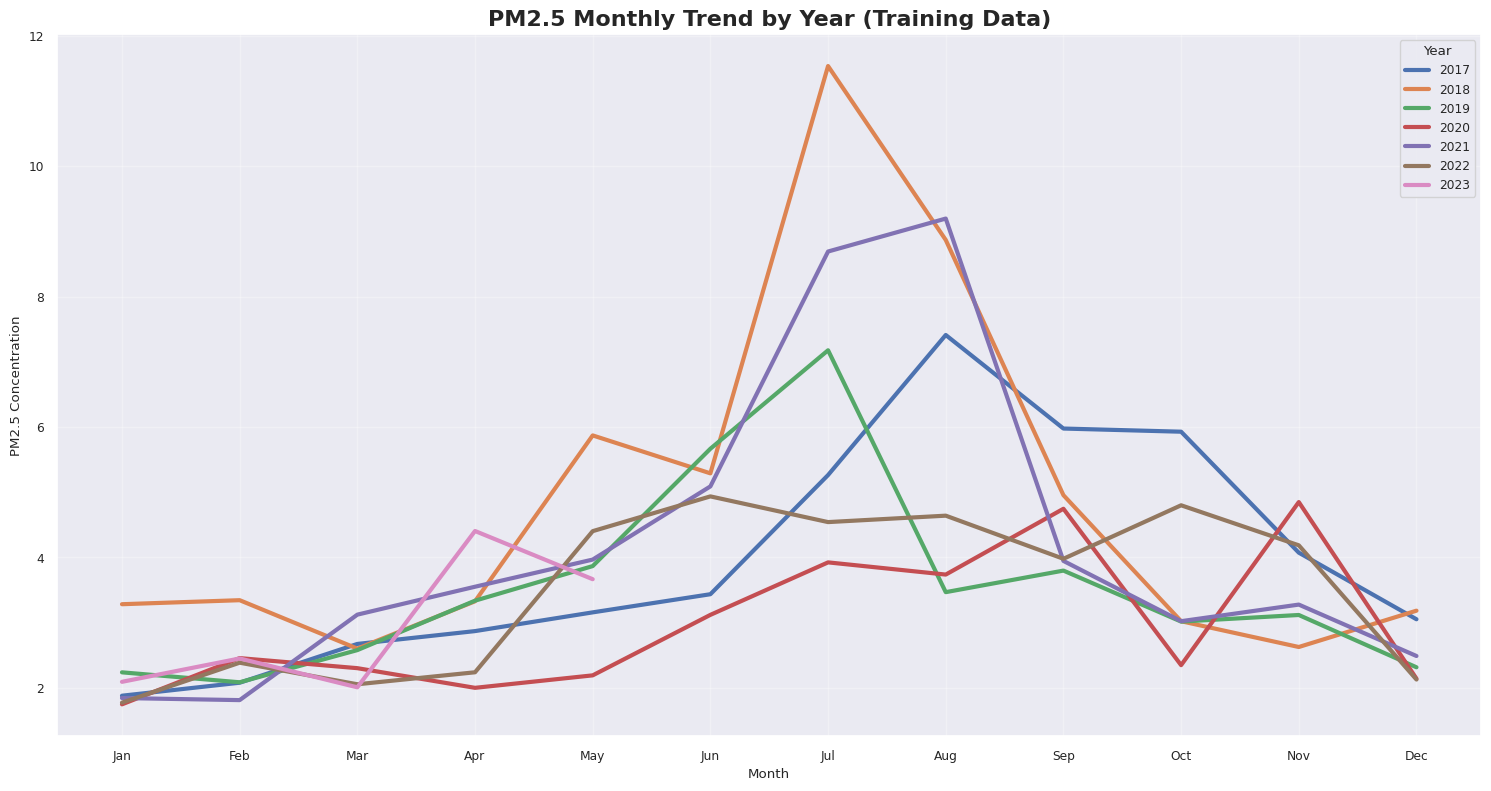

In [2551]:

data['date'] = pd.to_datetime(data['date'])

plot_df = data.iloc[train_idx].copy()


plot_df['month'] = plot_df['date'].dt.month
plot_df['year'] = plot_df['date'].dt.year

monthly_pm = plot_df.groupby(['year', 'month'])['pm25'].mean().reset_index()
pivot_pm = monthly_pm.pivot(index='month', columns='year', values='pm25')

plt.figure(figsize=(15,8))

for col in pivot_pm.columns:
    plt.plot(pivot_pm.index, pivot_pm[col], linewidth=3, label=str(col))

plt.xticks(
    range(1,13),
    ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
)

plt.title('PM2.5 Monthly Trend by Year (Training Data)', fontsize=16, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('PM2.5 Concentration')
plt.legend(title='Year')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [2552]:
y_train.isnull().sum()

np.int64(0)

In [2553]:
y_test.isnull().sum()

np.int64(0)

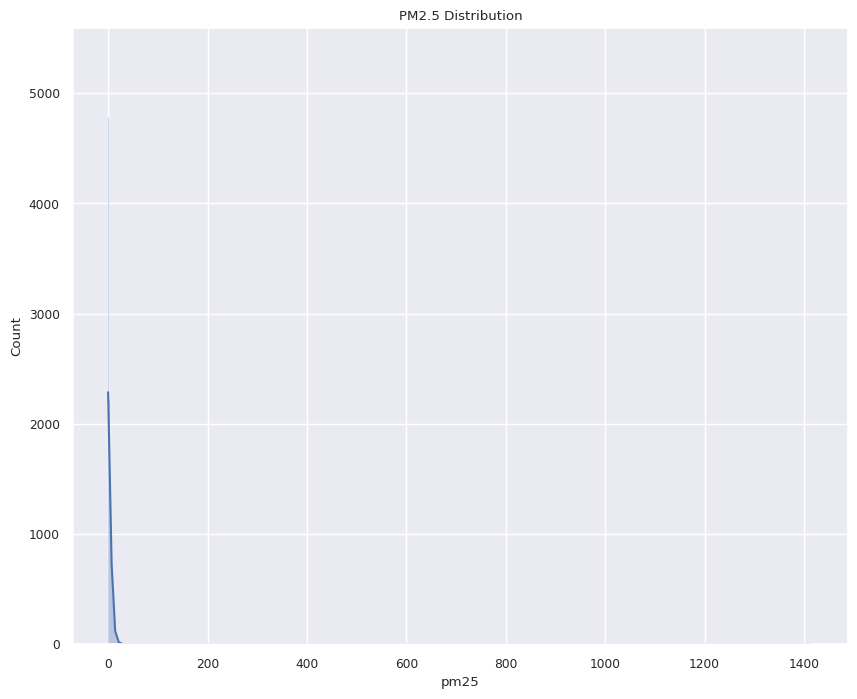

In [2554]:
plt.figure(figsize=(10,8))
sns.histplot(y_train,alpha=0.3,kde=True)

plt.title('PM2.5 Distribution')
plt.show()

<Axes: ylabel='pm25'>

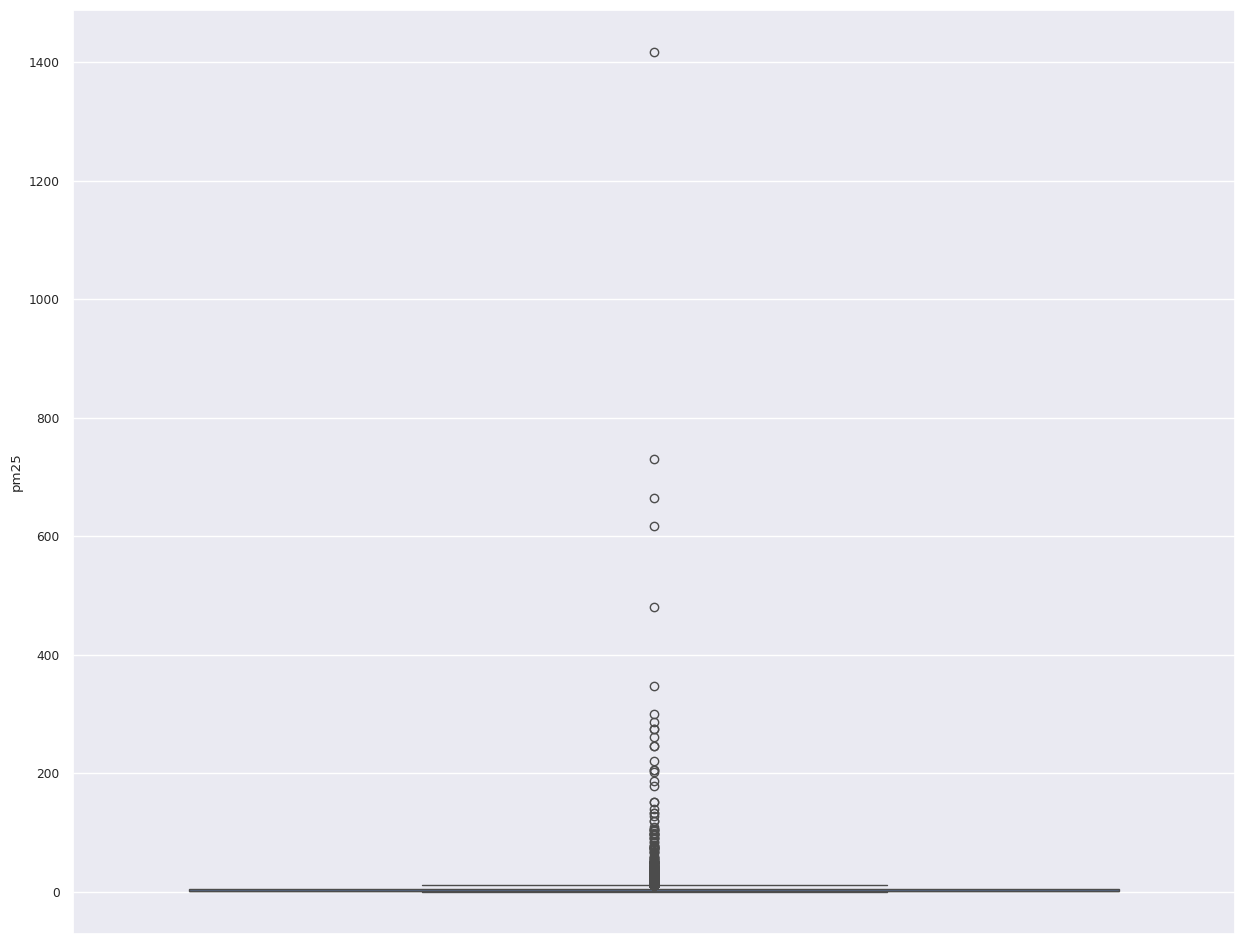

In [2555]:
sns.boxplot(y_train)

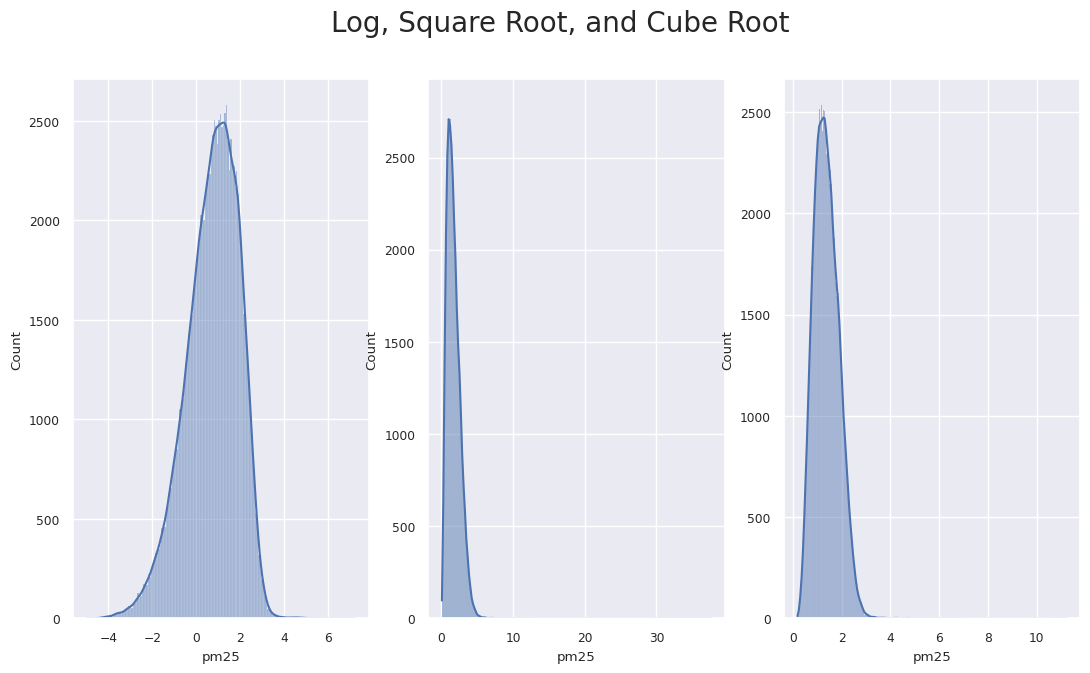

In [2556]:
x=np.log(y_train)
y=np.sqrt(y_train)
z=np.cbrt(y_train)

fig,ax=plt.subplots(1,3,figsize=(13,7))
for i,a in zip([x,y,z],ax):
  sns.histplot(i,ax=a,kde=True)

fig.suptitle('Log, Square Root, and Cube Root',fontsize=20)
plt.show()

**First plot – Log Transform (log(pm25))**

Shows a more centered distribution, closer to a bell shape

**Second plot – Square Root Transform (sqrt(pm25))**

Reduced skewness slightly but not as much as the log transform.

There is still a long right tail.

**hird plot – Cube Root Transform (cbrt(pm25))**

Shifts the shape closer to normal, but weaker than the log transform.

The cube root is a safe choice because it does not require strictly positive data.

**The best transformation visually is Log Transform, because it makes the distribution more balanced and closer to normal**



In [2557]:
y_train_transform=np.log1p(y_train)
y_test_transform=np.log1p(y_test)

<Axes: ylabel='pm25'>

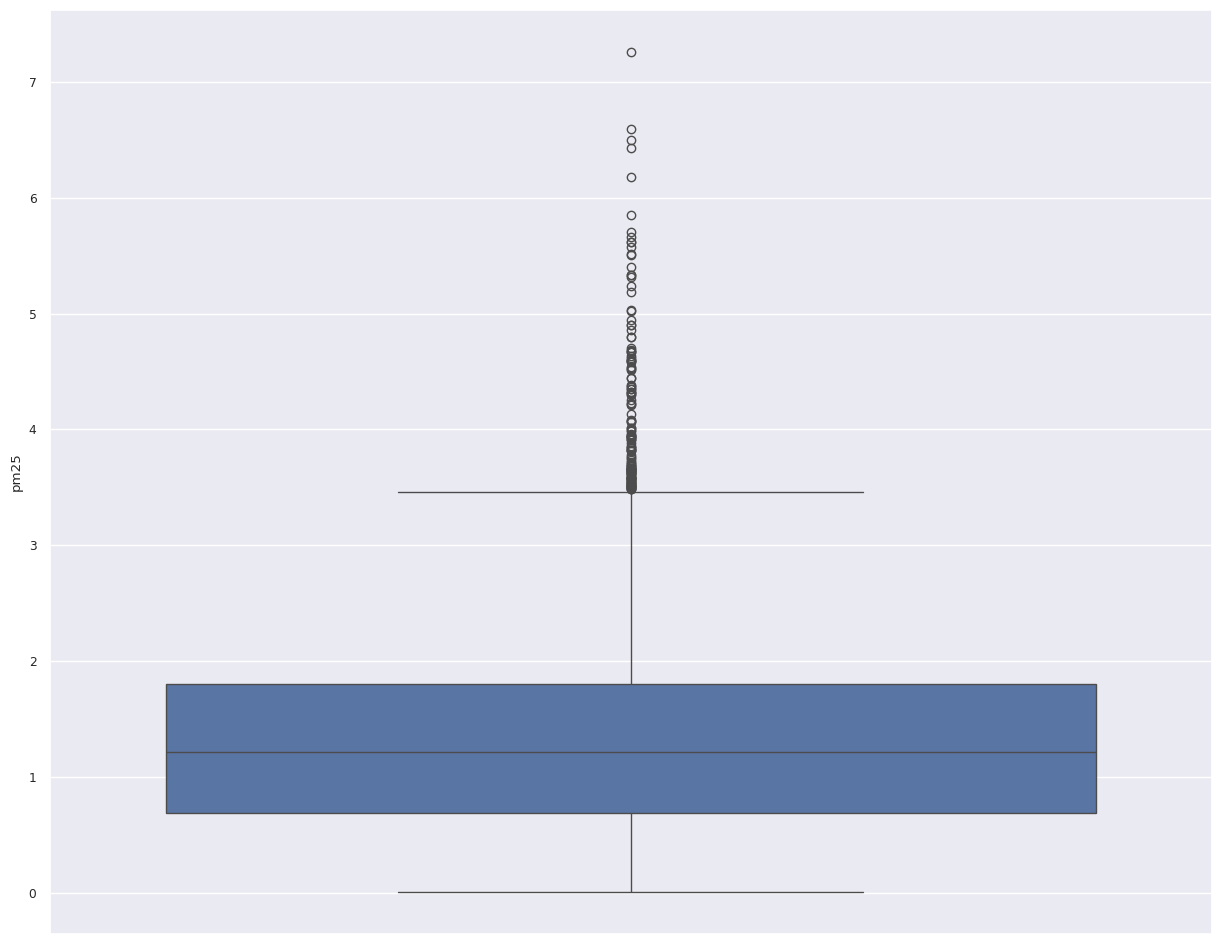

In [2558]:
sns.boxplot(y_train_transform)

Testing

In [2559]:
'''model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train_transform)'''

'model = RandomForestRegressor(random_state=42)\nmodel.fit(X_train, y_train_transform)'

In [2573]:
'''importances = pd.Series(model.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False).plot(kind='bar', title='Feature importance (Random Forest)')
plt.show()'''

"importances = pd.Series(model.feature_importances_, index=X_train.columns)\nimportances.sort_values(ascending=False).plot(kind='bar', title='Feature importance (Random Forest)')\nplt.show()"

It takes a long time to run, and I would also like to experiment with other methods for selecting or validating the features.

In [2561]:
cat_cols = ['city', 'FIRE_TYPE_CODE', 'FIRE_GENERAL_CAUSE_CODE', 'FIRE_RESPONSE_OBJ_CODE']
num_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
num_cols = num_cols.drop(cat_cols)
X_numeric = X_train[num_cols].copy()
train = X_numeric.copy()
train['target'] = y_train.values
target_corr = train.corr()['target'].abs().sort_values(ascending=False)
correlation_matrix = X_numeric.corr().abs()
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

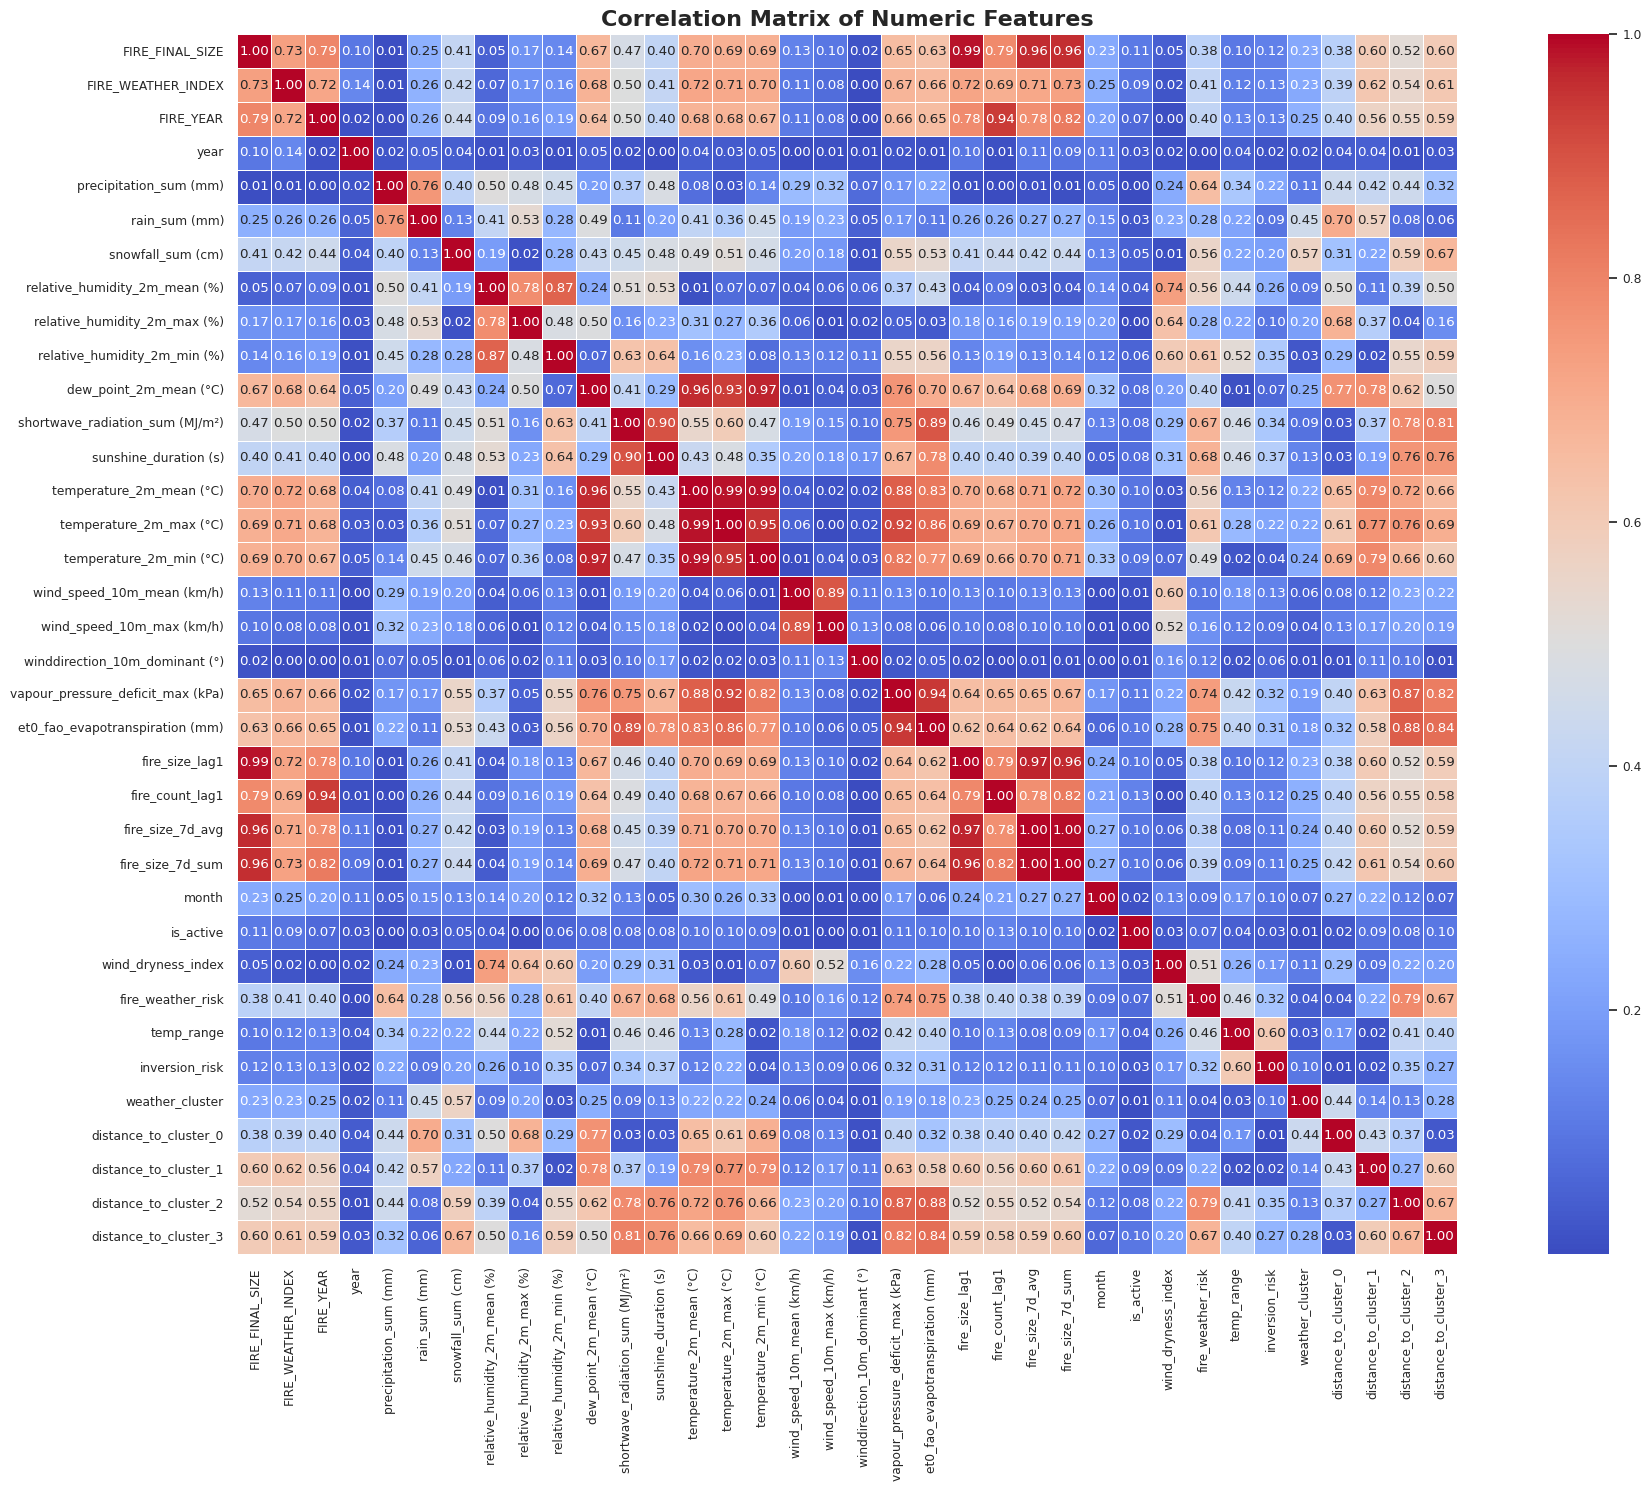

In [2562]:
plt.figure(figsize=(20, 15))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    cbar=True,
    square=True,
    linewidths=0.5
)
plt.title('Correlation Matrix of Numeric Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [2563]:
threshold = 0.9
checked = set()
high_corr_groups = []
for col in upper.columns:
    if col in checked:
        continue
    group = [col]
    for other_col in upper.columns:
        if other_col != col and upper.loc[col, other_col] > threshold:
            group.append(other_col)
    if len(group) > 1:
        high_corr_groups.append(group)
        checked.update(group)

In [2564]:
to_drop = []
for group in high_corr_groups:
    group_corrs = target_corr[group].sort_values(ascending=False)
    best_feature = group_corrs.index[0]
    others = group_corrs.index[1:]
    to_drop.extend(list(others))

In [2565]:
print("Dropped features:", to_drop)


Dropped features: ['fire_size_7d_sum', 'fire_size_lag1', 'FIRE_FINAL_SIZE', 'FIRE_YEAR', 'temperature_2m_mean (°C)', 'temperature_2m_min (°C)', 'temperature_2m_max (°C)', 'et0_fao_evapotranspiration (mm)']


In [2566]:
X_train.drop(columns=to_drop, inplace=True)
X_test.drop(columns=to_drop, inplace=True)

We removed features that were highly correlated with each other to reduce multicollinearity, which can make models unstable and harder to interpret. Keeping strongly correlated features adds redundant information and can cause the model to over-emphasize certain patterns without improving performance. By keeping only the feature with the strongest relationship to the target, we improve model efficiency, generalization, and interpretability

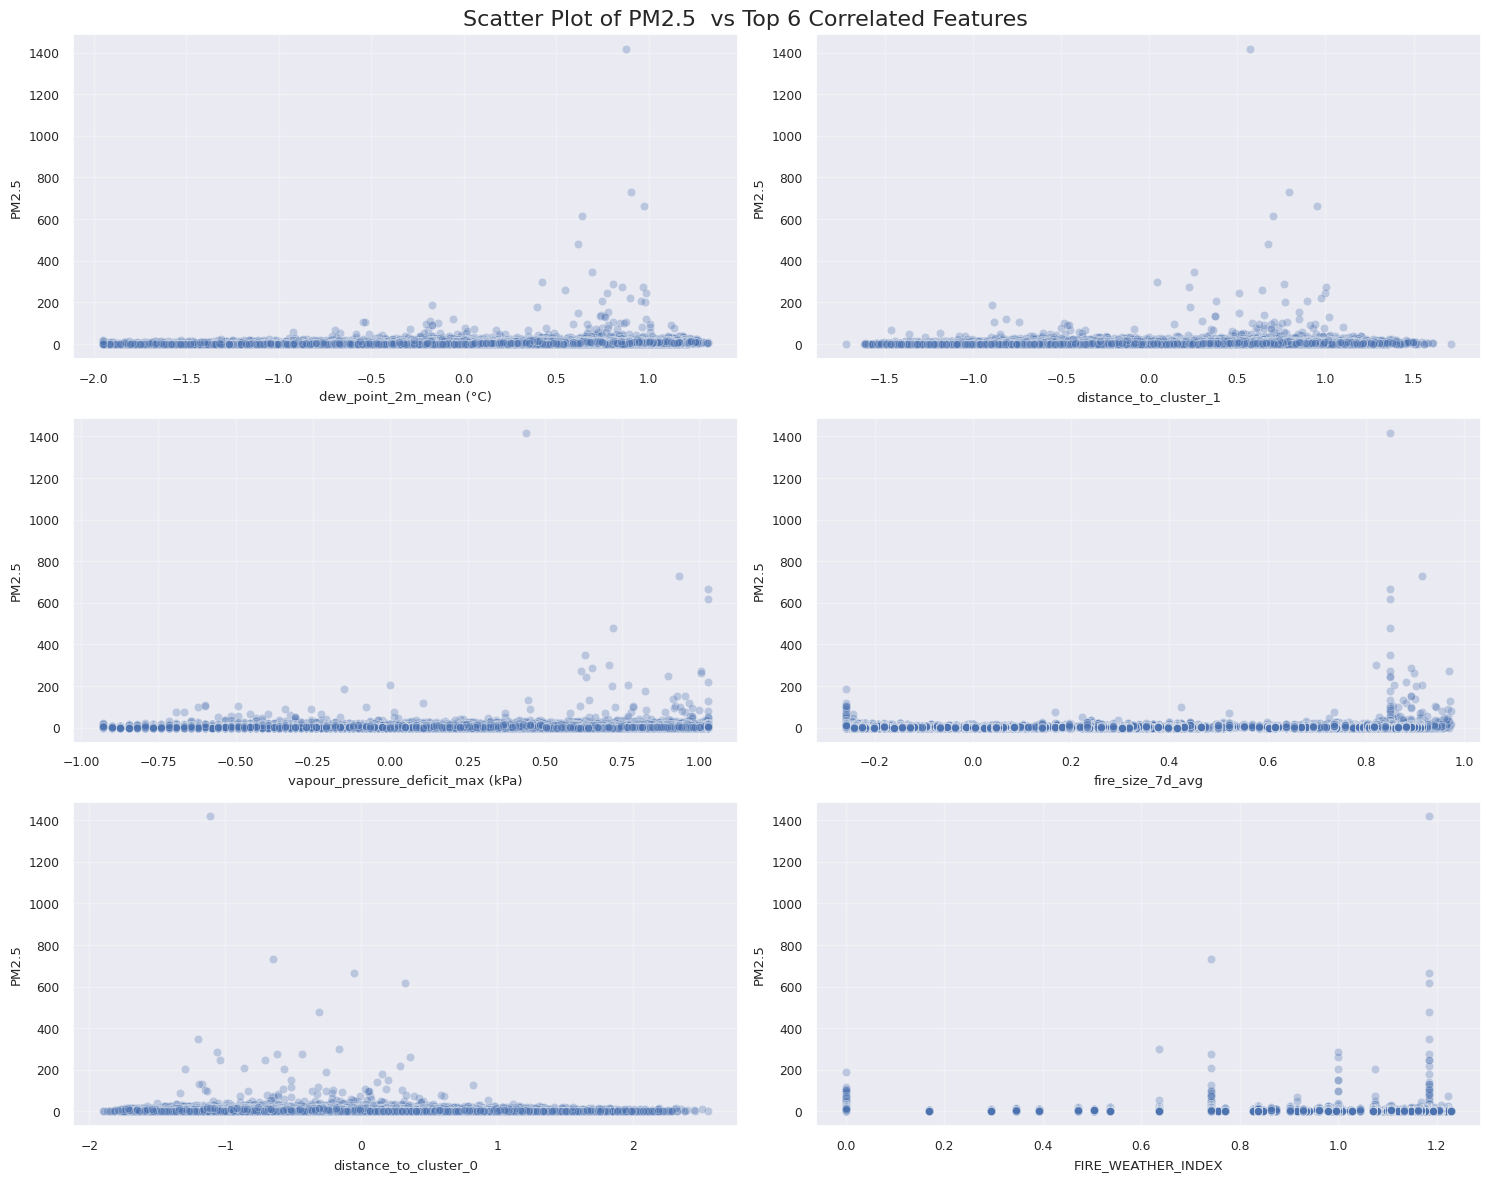

In [2567]:
corr_with_target = X_train.copy()
corr_with_target['target'] = y_train
corr_values = corr_with_target.corr(numeric_only=True)['target'].drop('target')

corr_values = corr_values.reindex(corr_values.abs().sort_values(ascending=False).index)


top6 = corr_values.head(6).index.tolist()

fig, ax = plt.subplots(3, 2, figsize=(15, 12))
ax = ax.flatten()

for feature, axis in zip(top6, ax):
    sns.scatterplot(data=X_train,x=feature,
        y=y_train,alpha=0.3,ax=axis)


    axis.set_ylabel('PM2.5')
    axis.set_xlabel(feature)
    axis.grid(alpha=0.3)

fig.suptitle('Scatter Plot of PM2.5  vs Top 6 Correlated Features', fontsize=16)
plt.tight_layout()
plt.show()

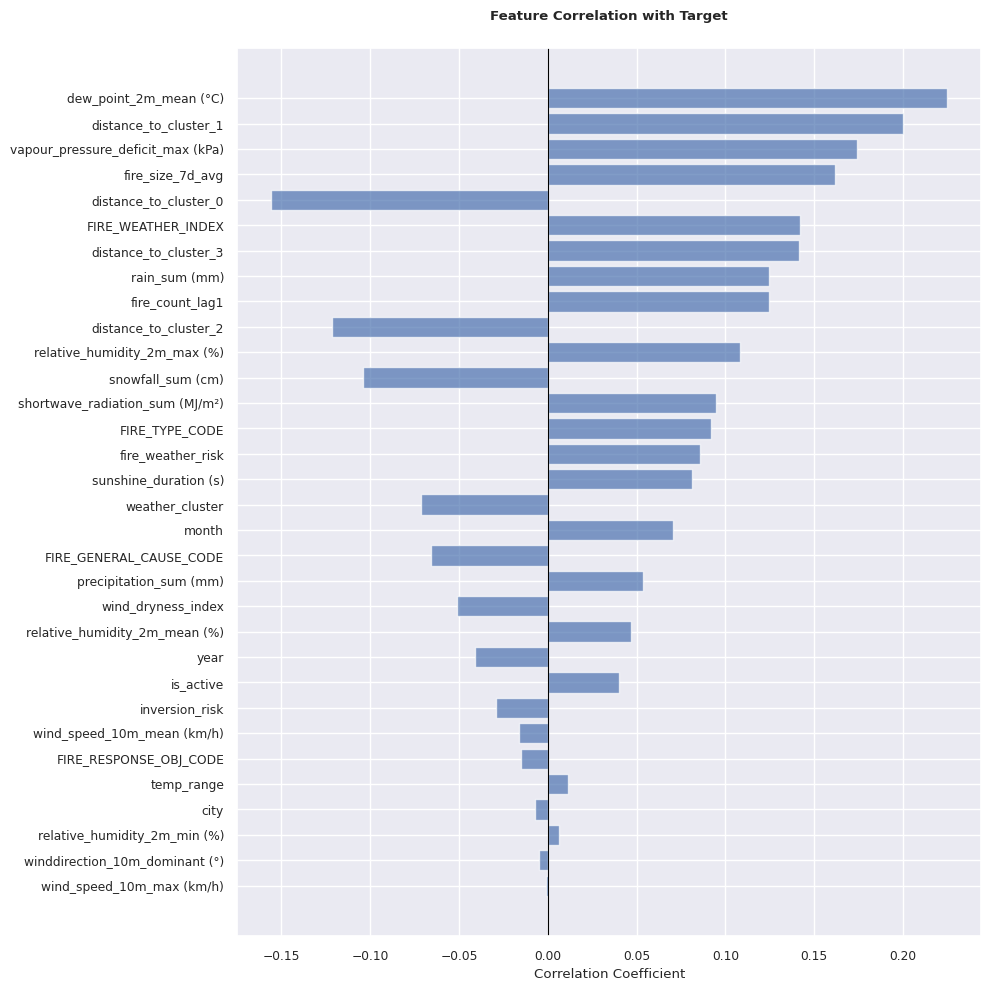

In [2568]:
corr_with_target = X_train.copy()
corr_with_target['target'] = y_train
corr_values = corr_with_target.corr(numeric_only=True)['target'].drop('target')
corr_values = corr_values.reindex(corr_values.abs().sort_values(ascending=False).index)

plt.figure(figsize=(10, 10))
plt.barh(corr_values.index, corr_values.values, alpha=0.7)
plt.axvline(x=0, color='black', linewidth=0.8)
plt.title('Feature Correlation with Target', fontweight='bold', pad=20)
plt.xlabel('Correlation Coefficient')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [2569]:
X_train

city  FIRE_WEATHER_INDEX  FIRE_TYPE_CODE  FIRE_GENERAL_CAUSE_CODE  \
0      -0.958333            0.000000            -1.0                      0.0   
1      -0.916667            0.000000            -1.0                      0.0   
2      -0.875000            0.000000            -1.0                      0.0   
3      -0.833333            0.000000            -1.0                      0.0   
4      -0.791667            0.000000            -1.0                      0.0   
...          ...                 ...             ...                      ...   
109863  0.041667            1.161782             0.0                     -1.0   
109864  0.083333            1.161782             0.0                     -1.0   
109865  0.125000            1.161782             0.0                     -1.0   
109866  0.166667            1.161782             0.0                     -1.0   
109867  0.208333            1.161782             0.0                     -1.0   

        FIRE_RESPONSE_OBJ_CODE  year  precipitation_sum (mm)  rain_sum (mm)  \
0                          0.5  -1.0                0.715683       0.000000   
1                          0.5  -1.0                0.333682       0.000000   
2                          0.5  -1.0                0.593969       0.000000   
3                          0.5  -1.0               -0.306375       0.000000   
4                          0.5  -1.0                0.575905       0.424319   
...                        ...   ...                     ...            ...   
109863                    -2.0   1.0                0.655816       0.243164   
109864                    -2.0   1.0               -0.306375       0.000000   
109865                    -2.0   1.0                0.513551       0.000000   
109866                    -2.0   1.0               -0.306375       0.000000   
109867                    -2.0   1.0               -0.306375       0.000000   

        snowfall_sum (cm)  relative_humidity_2m_mean (%)  ...  \
0                1.269443                         0.3750  ...   
1                1.269443                         0.5000  ...   
2                1.269443                         0.5000  ...   
3                0.000000                         0.1250  ...   
4                1.269443                         0.6250  ...   
...                   ...                            ...  ...   
109863           1.269443                        -0.8750  ...   
109864           0.000000                        -1.5625  ...   
109865           1.269443                         0.3125  ...   
109866           0.000000                        -1.3750  ...   
109867           0.000000                        -1.0625  ...   

        wind_dryness_index  fire_weather_risk  temp_range  inversion_risk  \
0                -0.272032          -0.706393   -0.600000        0.000000   
1                -0.302013          -0.827332   -0.818182        2.685944   
2                -0.097942          -0.614719   -0.290909        0.000000   
3                -0.330382          -0.027544    0.036364        0.000000   
4                -0.276138          -0.530605   -0.309091        0.000000   
...                    ...                ...         ...             ...   
109863            0.427735          -0.281985    0.127273        0.000000   
109864            1.096506           1.120110    1.345455        0.000000   
109865           -0.853596          -1.121472   -0.418182        0.000000   
109866            1.309078           1.003814    0.381818        0.000000   
109867            0.757384           1.101747    0.909091        0.000000   

        weather_cluster  distance_to_cluster_0  distance_to_cluster_1  \
0                   1.0              -0.093150              -0.551029   
1                   1.0               0.469552              -0.687842   
2                   1.0              -0.001861              -0.518392   
3                  -1.0               0.108214              -1.046667   
4                  

#summary statistics

In [2570]:
X_train.describe()

city  FIRE_WEATHER_INDEX  FIRE_TYPE_CODE  \
count  109868.000000       109868.000000   109868.000000   
mean       -0.000099            0.410126       -0.381585   
min        -0.958333            0.000000       -1.000000   
25%        -0.500000            0.000000       -1.000000   
50%         0.000000            0.000000        0.000000   
75%         0.500000            1.000000        0.000000   
max         0.958333            1.229192        2.000000   
std         0.565183            0.500797        0.627903   

       FIRE_GENERAL_CAUSE_CODE  FIRE_RESPONSE_OBJ_CODE           year  \
count            109868.000000           109868.000000  109868.000000   
mean                 -0.498635               -0.320084      -0.093421   
min                  -2.500000               -2.000000      -1.000000   
25%                  -1.000000               -0.500000      -0.666667   
50%                   0.000000                0.000000       0.000000   
75%                   0.000000                0.500000       0.333333   
max                   2.000000                0.500000       1.000000   
std                   0.833608                1.009871       0.619378   

       precipitation_sum (mm)  rain_sum (mm)  snowfall_sum (cm)  \
count           109868.000000  109868.000000      109868.000000   
mean                 0.170196       0.384290           0.335303   
min                 -0.306375       0.000000           0.000000   
25%                 -0.306375       0.000000           0.000000   
50%                  0.000000       0.000000           0.000000   
75%                  0.693625       1.000000           1.000000   
max                  0.918701       1.193567           1.269443   
std                  0.494042       0.507604           0.552641   

       relative_humidity_2m_mean (%)  ...  wind_dryness_index  \
count                  109868.000000  ...       109868.000000   
mean                       -0.059179  ...            0.011181   
min                        -2.000000  ...           -2.879611   
25%                        -0.500000  ...           -0.489927   
50%                         0.000000  ...            0.000000   
75%                         0.500000  ...            0.510073   
max                         1.625000  ...            2.636530   
std                         0.756150  ...            0.750065   

       fire_weather_risk     temp_range  inversion_risk  weather_cluster  \
count      109868.000000  109868.000000   109868.000000    109868.000000   
mean            0.020630       0.059137        0.446549        -0.455137   
min            -2.284798      -1.454545        0.000000        -2.000000   
25%            -0.460358      -0.472727        0.000000        -1.000000   
50%             0.000000       0.000000        0.000000         0.000000   
75%             0.539642       0.527273        0.000000         0.000000   
max             2.426139       3.745455        2.685944         1.000000   
std             0.662463       0.697978        1.000005         1.089043   

       distance_to_cluster_0  distance_to_cluster_1  distance_to_cluster_2  \
count          109868.000000           1.098680e+05          109868.000000   
mean               -0.023372          -2.078858e-02              -0.001513   
min                -1.898885          -1.721904e+00              -1.335112   
25%                -0.538107          -5.070363e-01              -0.506067   
50%                 0.000000           1.819738e-16               0.000000   
75%                 0.461893           4.929637e-01               0.493933   
max                 2.550558           1.712115e+00               1.631790   
std                 0.716000           6.147520e-01               0.591603   

       distance_to_cluster_3                           date  
count           1.098680e+05                         109868  
mean            2.890301e-02  2020-03-14 07:24:19.686168576  
min            -1.558746e+00            2017-01-01 00

In [2571]:
df.describe()

date            lat            lon  \
count                         139502  139502.000000  139502.000000   
mean   2020-12-28 01:16:49.791973888      46.996808     -82.018417   
min              2017-01-01 00:00:00      44.485500     -94.292200   
25%              2018-12-25 00:00:00      45.200100     -83.717000   
50%              2020-12-30 00:00:00      46.352200     -79.914700   
75%              2022-12-29 00:00:00      48.684400     -78.460600   
max              2024-12-31 00:00:00      52.106900     -76.527800   
std                              NaN       2.033204       4.823376   

                pm25           year  precipitation_sum (mm)  rain_sum (mm)  \
count  139502.000000  139502.000000           139502.000000  139502.000000   
mean        4.099721    2020.491040                2.551007       1.921572   
min         0.001337    2017.000000                0.000000       0.000000   
25%         0.989316    2018.000000                0.000000       0.000000   
50%         2.503802    2020.000000                0.300000       0.000000   
75%         5.502272    2022.000000                2.600000       1.100000   
max      1417.456644    2024.000000              103.400000     103.400000   
std         7.633472       2.290909                5.206069       4.863637   

       snowfall_sum (cm)  relative_humidity_2m_mean (%)  \
count      139502.000000                  139502.000000   
mean            0.442133                      73.124349   
min             0.000000                       2.000000   
25%             0.000000                      67.000000   
50%             0.000000                      75.000000   
75%             0.000000                      82.000000   
max            28.840000                     100.000000   
std             1.459891                      12.861413   

       relative_humidity_2m_max (%)  ...  winddirection_10m_dominant (°)  \
count                 139502.000000  ...                   139502.000000   
mean                      88.992265  ...                      209.113203   
min                        4.000000  ...                        0.000000   
25%                       84.000000  ...                      141.000000   
50%                       91.000000  ...                      227.000000   
75%                       97.000000  ...                      286.000000   
max                      100.000000  ...                      360.000000   
std                       10.782353  ...                       96.034682   

       vapour_pressure_deficit_max (kPa)  et0_fao_evapotranspiration (mm)  \
count                      139502.000000                    139502.000000   
mean                            0.802482                         2.134374   
min                             0.000000                         0.080000   
25%                             0.210000                         0.630000   
50%                             0.550000                         1.640000   
75%                             1.210000                         3.420000   
max                             6.850000                        10.270000   
std                             0.749837                         1.697140   

        index_right                FIRE_START_DATE  FIRE_WEATHER_INDEX  \
count   5342.000000                          83666        83666.000000   
mean   59874.317297  2021-02-02 03:56:52.741137664            8.061200   
min    56097.000000            2017-04-07 00:00:00            0.000000   
25%    57573.250000            2019-05-29 00:00:00            0.900000   
50%    59086.000000            2020-11-26 00:00:00            5.500000   
75%    62536.750000            2023-04-27 00:00:00           16.000000   
max    65005.000000            2024-10-29 00:00:00           39.000000   
std     2825.449425                            NaN            8.728794   

                       FIRE_OUT_DATE     FIRE_YEAR        OGF_ID  \
count                          83666  83666.000000  

This file still requires further refinements and the possible addition of new features. In addition, some explanations are incomplete and the plots need clearer and more detailed interpretation. These improvements will be implemented and all details will be fully presented in M3.